In [30]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
np.set_printoptions(suppress=True)

import tensorflow as tf
import bayesflow as bf
from bayesflow.experimental.rectifiers import RectifiedDistribution
from helpers import ConfigurableMLP

from

# Data Loading

In [22]:
simulations = np.load('../simulations/sim_data.npy').astype(np.float32)
parameters = pd.read_csv('../simulations/params.csv', header=0, delimiter=';') 

In [3]:
parameters.head()

HRF Time to Peak Detector 1  HRF Amplitude Detector 1  \
0                       7.0338                  0.001629   
1                       5.2345                  0.001773   
2                       5.7475                  0.001626   
3                       7.3146                  0.000762   
4                       6.5463                  0.001503   

   HRF Width Detector 1  HRF Time to Peak Detector 2  \
0                7.7560                       6.9460   
1                7.3385                       5.8981   
2                4.9959                       6.7467   
3                8.0341                       8.4775   
4                6.7617                       8.4967   

   HRF Amplitude Detector 2  HRF Width Detector 2  \
0                  0.001019                6.0031   
1                  0.000869                7.6492   
2                  0.001758                5.8431   
3                  0.001518                6.0373   
4                  0.001190                6.8032   

   HRF Time to Peak Detector 3  HRF Amplitude Detector 3  \
0                       7.8526                  0.001698   
1                       6.2581                  0.000796   
2                       5.7991                  0.001139   
3                       6.5384                  0.001310   
4                       5.5991                  0.000671   

   HRF Width Detector 3  HRF Time to Peak Detector 4  ...  \
0                6.2628                       5.8639  ...   
1                6.4322                       5.5169  ...   
2                7.2573                       7.6944  ...   
3                7.7039                       7.4151  ...   
4                7.1297                       5.9724  ...   

   HRF Width Detector 16  Systemic Physio Scale  Mayers Amplitude  \
0                 7.0313                0.18182            5.2608   
1                 5.1956                0.52632            6.8568   
2                 7.9665                0.15873            3.6423   
3                 5.0208                0.23810            5.9529   
4                 5.1125                0.52632            4.3666   

   Mayers Frequency  Respiratory Amplitude  Respiratory Frequency  \
0          0.102240                0.74142                0.44939   
1          0.108460                1.26700                0.48831   
2          0.102290                1.00080                0.42822   
3          0.092219                0.86838                0.51156   
4          0.093311                0.62905                0.33892   

   Cardiac Amplitude  Cardiac Frequency  VLFO Amplitude  VLFO Frequency  
0             5.0819                1.1         99987.0        0.008413  
1             7.2629                0.9         99972.0        0.010997  
2             4.4721                1.2         99986.0        0.011874  
3             7.4399                1.0         99971.0        0.011116  
4             2.2878                0.9         99965.0        0.008594  

[5 rows x 57 columns]

In [4]:
parameter_names = list(parameters.columns)
parameters = parameters.values.astype(np.float32)

<Axes: xlabel='Mayers Frequency', ylabel='Count'>

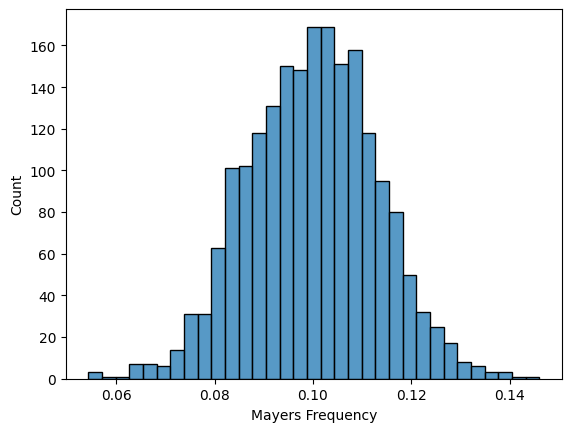

In [23]:
sns.histplot(parameters['Mayers Frequency'])

In [5]:
print(simulations.shape)
print(parameters.shape)

(2000, 1501, 102)
(2000, 57)


Get rid of cardiac frequency, as it is a discrete parameter.

In [6]:
idx_cf = parameter_names.index('Cardiac Frequency')
parameters = np.delete(parameters, idx_cf, axis=1)
parameter_names = parameter_names[:idx_cf] + parameter_names[idx_cf+1:]

## Preprocessing
Before we throw our simulations into the BayesFlow networks, we need to ensure that they are properly preprocessed, as in standard deep learning application.

In [7]:
# Compute and store date and parameter means
params_means = parameters.mean(axis=0)
params_stds = parameters.std(axis=0)
data_means = simulations.mean(axis=(0, 1))
data_stds = simulations.std(axis=(0, 1))

# Train test split
num_train = 1800
num_val = 100
num_test = simulations.shape[0] - (num_train + num_val)
idx = np.random.default_rng(42).permutation(simulations.shape[0])

train_data = {
    'prior_draws': parameters[idx[:num_train]],
    'sim_data': simulations[idx[:num_train]]
}

val_data = {
    'prior_draws': parameters[idx[num_train:num_train+num_val]],
    'sim_data': simulations[idx[num_train:num_train+num_val]]
}

test_data = {
    'prior_draws': parameters[idx[-num_test:]],
    'sim_data': simulations[idx[-num_test:]]
}

In [8]:
def configurator(sim_dict, ds_factor=3):
    """Custom configurator will be passed to the BayesFlow trainer."""
    
    # Standardize batch with global mean and std
    std_params = (sim_dict['prior_draws'] - params_means) / params_stds
    std_data = (sim_dict['sim_data'] - data_means) / data_stds
    
    # Positional encodings
    ts = np.linspace(0, 1, std_data.shape[1], dtype=np.float32)
    
    # Downsample x3
    std_data = std_data[:, ::ds_factor, :]
    ts = ts[::ds_factor, np.newaxis]
    
    # Add positional encodings
    std_data = np.c_[std_data, [ts]*std_data.shape[0]]
    
    # Return in BayesFlow format for parameter estimation
    out_dict = dict(parameters=std_params, summary_conditions=std_data)
    return out_dict

## Networks

In [9]:
# Will compress the time series into a vector of 64 summary dims
summary_network = bf.networks.TimeSeriesTransformer(
    input_dim=103, 
    summary_dim=64,
    bidirectional=True,
    template_type='lstm',
    attention_settings={"key_dim": 64, "num_heads": 4, "dropout": 0.2},
)



# Will infer the parameters
inference_network = DriftNetwork(
    input_dim=len(parameter_names),
    cond_dim=64, 
    hidden_dim=512,
    num_hidden=4,
    activation='relu',
    residual_connections=True,
    dropout_rate=0.2
)

# Wraps summary and inference network
amortizer = RectifiedDistribution(inference_network, summary_network)

2023-11-27 17:52:31.832662: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 17:52:31.847068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-27 17:52:31.847163: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Training

In [10]:
trainer = bf.trainers.Trainer(
    amortizer=amortizer,
    configurator=configurator,
    checkpoint_path='../checkpoints/fm_naive'
)

INFO:root:Trainer initialization: No generative model provided. Only offline learning mode is available!
INFO:root:Initialized empty loss history.
INFO:root:Initialized networks from scratch.


In [11]:
h = trainer.train_offline(train_data, epochs=2000, batch_size=32, validation_sims=val_data)

Training epoch 1:   0%|          | 0/57 [00:00<?, ?it/s]

2023-11-27 17:52:55.492106: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-27 17:52:55.516427: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-27 17:52:55.649974: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f63593c55f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-27 17:52:55.649985: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2023-11-27 17:52:55.652722: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-27 17:52:55.722885: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

Training epoch 2:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2, Loss: 0.660


Training epoch 3:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 3, Loss: 0.650


Training epoch 4:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 4, Loss: 0.639


Training epoch 5:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 5, Loss: 0.629


Training epoch 6:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 6, Loss: 0.627


Training epoch 7:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 7, Loss: 0.623


Training epoch 8:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 8, Loss: 0.626


Training epoch 9:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 9, Loss: 0.626


Training epoch 10:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 10, Loss: 0.609


Training epoch 11:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 11, Loss: 0.608


Training epoch 12:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 12, Loss: 0.595


Training epoch 13:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 13, Loss: 0.611


Training epoch 14:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 14, Loss: 0.608


Training epoch 15:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 15, Loss: 0.588


Training epoch 16:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 16, Loss: 0.588


Training epoch 17:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 17, Loss: 0.587


Training epoch 18:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 18, Loss: 0.592


Training epoch 19:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 19, Loss: 0.581


Training epoch 20:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 20, Loss: 0.599


Training epoch 21:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 21, Loss: 0.580


Training epoch 22:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 22, Loss: 0.574


Training epoch 23:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 23, Loss: 0.571


Training epoch 24:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 24, Loss: 0.571


Training epoch 25:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 25, Loss: 0.564


Training epoch 26:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 26, Loss: 0.574


Training epoch 27:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 27, Loss: 0.582


Training epoch 28:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 28, Loss: 0.574


Training epoch 29:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 29, Loss: 0.566


Training epoch 30:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 30, Loss: 0.567


Training epoch 31:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 31, Loss: 0.572


Training epoch 32:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 32, Loss: 0.559


Training epoch 33:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 33, Loss: 0.569


Training epoch 34:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 34, Loss: 0.581


Training epoch 35:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 35, Loss: 0.563


Training epoch 36:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 36, Loss: 0.563


Training epoch 37:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 37, Loss: 0.562


Training epoch 38:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 38, Loss: 0.555


Training epoch 39:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 39, Loss: 0.556


Training epoch 40:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 40, Loss: 0.571


Training epoch 41:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 41, Loss: 0.540


Training epoch 42:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 42, Loss: 0.549


Training epoch 43:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 43, Loss: 0.547


Training epoch 44:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 44, Loss: 0.553


Training epoch 45:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 45, Loss: 0.532


Training epoch 46:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 46, Loss: 0.544


Training epoch 47:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 47, Loss: 0.543


Training epoch 48:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 48, Loss: 0.540


Training epoch 49:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 49, Loss: 0.529


Training epoch 50:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 50, Loss: 0.540


Training epoch 51:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 51, Loss: 0.555


Training epoch 52:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 52, Loss: 0.540


Training epoch 53:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 53, Loss: 0.542


Training epoch 54:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 54, Loss: 0.539


Training epoch 55:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 55, Loss: 0.565


Training epoch 56:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 56, Loss: 0.543


Training epoch 57:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 57, Loss: 0.542


Training epoch 58:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 58, Loss: 0.534


Training epoch 59:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 59, Loss: 0.535


Training epoch 60:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 60, Loss: 0.527


Training epoch 61:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 61, Loss: 0.540


Training epoch 62:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 62, Loss: 0.536


Training epoch 63:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 63, Loss: 0.541


Training epoch 64:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 64, Loss: 0.531


Training epoch 65:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 65, Loss: 0.520


Training epoch 66:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 66, Loss: 0.519


Training epoch 67:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 67, Loss: 0.524


Training epoch 68:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 68, Loss: 0.518


Training epoch 69:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 69, Loss: 0.521


Training epoch 70:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 70, Loss: 0.506


Training epoch 71:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 71, Loss: 0.526


Training epoch 72:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 72, Loss: 0.521


Training epoch 73:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 73, Loss: 0.522


Training epoch 74:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 74, Loss: 0.517


Training epoch 75:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 75, Loss: 0.522


Training epoch 76:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 76, Loss: 0.522


Training epoch 77:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 77, Loss: 0.501


Training epoch 78:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 78, Loss: 0.531


Training epoch 79:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 79, Loss: 0.525


Training epoch 80:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 80, Loss: 0.524


Training epoch 81:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 81, Loss: 0.522


Training epoch 82:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 82, Loss: 0.515


Training epoch 83:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 83, Loss: 0.510


Training epoch 84:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 84, Loss: 0.516


Training epoch 85:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 85, Loss: 0.525


Training epoch 86:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 86, Loss: 0.533


Training epoch 87:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 87, Loss: 0.503


Training epoch 88:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 88, Loss: 0.529


Training epoch 89:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 89, Loss: 0.515


Training epoch 90:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 90, Loss: 0.517


Training epoch 91:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 91, Loss: 0.509


Training epoch 92:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 92, Loss: 0.530


Training epoch 93:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 93, Loss: 0.501


Training epoch 94:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 94, Loss: 0.505


Training epoch 95:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 95, Loss: 0.533


Training epoch 96:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 96, Loss: 0.520


Training epoch 97:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 97, Loss: 0.513


Training epoch 98:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 98, Loss: 0.514


Training epoch 99:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 99, Loss: 0.520


Training epoch 100:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 100, Loss: 0.519


Training epoch 101:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 101, Loss: 0.525


Training epoch 102:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 102, Loss: 0.520


Training epoch 103:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 103, Loss: 0.504


Training epoch 104:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 104, Loss: 0.517


Training epoch 105:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 105, Loss: 0.509


Training epoch 106:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 106, Loss: 0.523


Training epoch 107:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 107, Loss: 0.527


Training epoch 108:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 108, Loss: 0.512


Training epoch 109:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 109, Loss: 0.517


Training epoch 110:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 110, Loss: 0.521


Training epoch 111:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 111, Loss: 0.512


Training epoch 112:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 112, Loss: 0.514


Training epoch 113:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 113, Loss: 0.508


Training epoch 114:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 114, Loss: 0.517


Training epoch 115:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 115, Loss: 0.517


Training epoch 116:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 116, Loss: 0.520


Training epoch 117:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 117, Loss: 0.519


Training epoch 118:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 118, Loss: 0.520


Training epoch 119:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 119, Loss: 0.513


Training epoch 120:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 120, Loss: 0.514


Training epoch 121:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 121, Loss: 0.511


Training epoch 122:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 122, Loss: 0.523


Training epoch 123:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 123, Loss: 0.527


Training epoch 124:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 124, Loss: 0.523


Training epoch 125:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 125, Loss: 0.517


Training epoch 126:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 126, Loss: 0.509


Training epoch 127:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 127, Loss: 0.506


Training epoch 128:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 128, Loss: 0.513


Training epoch 129:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 129, Loss: 0.511


Training epoch 130:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 130, Loss: 0.520


Training epoch 131:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 131, Loss: 0.513


Training epoch 132:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 132, Loss: 0.514


Training epoch 133:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 133, Loss: 0.530


Training epoch 134:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 134, Loss: 0.520


Training epoch 135:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 135, Loss: 0.513


Training epoch 136:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 136, Loss: 0.521


Training epoch 137:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 137, Loss: 0.526


Training epoch 138:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 138, Loss: 0.502


Training epoch 139:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 139, Loss: 0.533


Training epoch 140:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 140, Loss: 0.517


Training epoch 141:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 141, Loss: 0.515


Training epoch 142:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 142, Loss: 0.524


Training epoch 143:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 143, Loss: 0.507


Training epoch 144:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 144, Loss: 0.526


Training epoch 145:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 145, Loss: 0.521


Training epoch 146:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 146, Loss: 0.517


Training epoch 147:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 147, Loss: 0.511


Training epoch 148:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 148, Loss: 0.522


Training epoch 149:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 149, Loss: 0.520


Training epoch 150:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 150, Loss: 0.504


Training epoch 151:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 151, Loss: 0.522


Training epoch 152:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 152, Loss: 0.505


Training epoch 153:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 153, Loss: 0.503


Training epoch 154:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 154, Loss: 0.517


Training epoch 155:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 155, Loss: 0.527


Training epoch 156:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 156, Loss: 0.527


Training epoch 157:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 157, Loss: 0.520


Training epoch 158:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 158, Loss: 0.511


Training epoch 159:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 159, Loss: 0.517


Training epoch 160:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 160, Loss: 0.503


Training epoch 161:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 161, Loss: 0.510


Training epoch 162:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 162, Loss: 0.509


Training epoch 163:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 163, Loss: 0.517


Training epoch 164:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 164, Loss: 0.514


Training epoch 165:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 165, Loss: 0.525


Training epoch 166:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 166, Loss: 0.519


Training epoch 167:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 167, Loss: 0.516


Training epoch 168:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 168, Loss: 0.519


Training epoch 169:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 169, Loss: 0.528


Training epoch 170:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 170, Loss: 0.499


Training epoch 171:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 171, Loss: 0.522


Training epoch 172:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 172, Loss: 0.530


Training epoch 173:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 173, Loss: 0.515


Training epoch 174:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 174, Loss: 0.524


Training epoch 175:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 175, Loss: 0.520


Training epoch 176:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 176, Loss: 0.518


Training epoch 177:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 177, Loss: 0.522


Training epoch 178:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 178, Loss: 0.517


Training epoch 179:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 179, Loss: 0.512


Training epoch 180:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 180, Loss: 0.512


Training epoch 181:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 181, Loss: 0.533


Training epoch 182:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 182, Loss: 0.508


Training epoch 183:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 183, Loss: 0.523


Training epoch 184:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 184, Loss: 0.514


Training epoch 185:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 185, Loss: 0.530


Training epoch 186:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 186, Loss: 0.513


Training epoch 187:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 187, Loss: 0.518


Training epoch 188:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 188, Loss: 0.526


Training epoch 189:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 189, Loss: 0.506


Training epoch 190:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 190, Loss: 0.522


Training epoch 191:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 191, Loss: 0.523


Training epoch 192:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 192, Loss: 0.508


Training epoch 193:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 193, Loss: 0.531


Training epoch 194:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 194, Loss: 0.508


Training epoch 195:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 195, Loss: 0.533


Training epoch 196:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 196, Loss: 0.513


Training epoch 197:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 197, Loss: 0.539


Training epoch 198:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 198, Loss: 0.510


Training epoch 199:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 199, Loss: 0.531


Training epoch 200:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 200, Loss: 0.523


Training epoch 201:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 201, Loss: 0.532


Training epoch 202:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 202, Loss: 0.542


Training epoch 203:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 203, Loss: 0.517


Training epoch 204:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 204, Loss: 0.512


Training epoch 205:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 205, Loss: 0.520


Training epoch 206:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 206, Loss: 0.532


Training epoch 207:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 207, Loss: 0.517


Training epoch 208:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 208, Loss: 0.525


Training epoch 209:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 209, Loss: 0.504


Training epoch 210:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 210, Loss: 0.539


Training epoch 211:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 211, Loss: 0.537


Training epoch 212:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 212, Loss: 0.516


Training epoch 213:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 213, Loss: 0.525


Training epoch 214:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 214, Loss: 0.531


Training epoch 215:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 215, Loss: 0.524


Training epoch 216:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 216, Loss: 0.527


Training epoch 217:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 217, Loss: 0.532


Training epoch 218:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 218, Loss: 0.534


Training epoch 219:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 219, Loss: 0.523


Training epoch 220:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 220, Loss: 0.521


Training epoch 221:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 221, Loss: 0.516


Training epoch 222:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 222, Loss: 0.536


Training epoch 223:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 223, Loss: 0.527


Training epoch 224:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 224, Loss: 0.525


Training epoch 225:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 225, Loss: 0.543


Training epoch 226:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 226, Loss: 0.529


Training epoch 227:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 227, Loss: 0.543


Training epoch 228:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 228, Loss: 0.527


Training epoch 229:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 229, Loss: 0.542


Training epoch 230:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 230, Loss: 0.544


Training epoch 231:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 231, Loss: 0.540


Training epoch 232:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 232, Loss: 0.533


Training epoch 233:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 233, Loss: 0.532


Training epoch 234:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 234, Loss: 0.515


Training epoch 235:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 235, Loss: 0.544


Training epoch 236:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 236, Loss: 0.542


Training epoch 237:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 237, Loss: 0.544


Training epoch 238:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 238, Loss: 0.520


Training epoch 239:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 239, Loss: 0.523


Training epoch 240:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 240, Loss: 0.528


Training epoch 241:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 241, Loss: 0.520


Training epoch 242:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 242, Loss: 0.527


Training epoch 243:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 243, Loss: 0.529


Training epoch 244:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 244, Loss: 0.543


Training epoch 245:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 245, Loss: 0.528


Training epoch 246:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 246, Loss: 0.528


Training epoch 247:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 247, Loss: 0.542


Training epoch 248:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 248, Loss: 0.532


Training epoch 249:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 249, Loss: 0.552


Training epoch 250:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 250, Loss: 0.521


Training epoch 251:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 251, Loss: 0.546


Training epoch 252:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 252, Loss: 0.557


Training epoch 253:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 253, Loss: 0.526


Training epoch 254:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 254, Loss: 0.534


Training epoch 255:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 255, Loss: 0.538


Training epoch 256:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 256, Loss: 0.556


Training epoch 257:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 257, Loss: 0.518


Training epoch 258:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 258, Loss: 0.549


Training epoch 259:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 259, Loss: 0.541


Training epoch 260:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 260, Loss: 0.550


Training epoch 261:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 261, Loss: 0.546


Training epoch 262:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 262, Loss: 0.528


Training epoch 263:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 263, Loss: 0.544


Training epoch 264:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 264, Loss: 0.557


Training epoch 265:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 265, Loss: 0.543


Training epoch 266:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 266, Loss: 0.552


Training epoch 267:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 267, Loss: 0.536


Training epoch 268:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 268, Loss: 0.549


Training epoch 269:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 269, Loss: 0.561


Training epoch 270:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 270, Loss: 0.534


Training epoch 271:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 271, Loss: 0.546


Training epoch 272:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 272, Loss: 0.568


Training epoch 273:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 273, Loss: 0.543


Training epoch 274:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 274, Loss: 0.554


Training epoch 275:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 275, Loss: 0.555


Training epoch 276:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 276, Loss: 0.546


Training epoch 277:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 277, Loss: 0.551


Training epoch 278:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 278, Loss: 0.536


Training epoch 279:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 279, Loss: 0.550


Training epoch 280:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 280, Loss: 0.566


Training epoch 281:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 281, Loss: 0.542


Training epoch 282:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 282, Loss: 0.565


Training epoch 283:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 283, Loss: 0.551


Training epoch 284:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 284, Loss: 0.566


Training epoch 285:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 285, Loss: 0.547


Training epoch 286:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 286, Loss: 0.554


Training epoch 287:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 287, Loss: 0.542


Training epoch 288:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 288, Loss: 0.558


Training epoch 289:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 289, Loss: 0.552


Training epoch 290:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 290, Loss: 0.557


Training epoch 291:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 291, Loss: 0.568


Training epoch 292:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 292, Loss: 0.533


Training epoch 293:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 293, Loss: 0.555


Training epoch 294:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 294, Loss: 0.544


Training epoch 295:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 295, Loss: 0.565


Training epoch 296:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 296, Loss: 0.553


Training epoch 297:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 297, Loss: 0.548


Training epoch 298:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 298, Loss: 0.580


Training epoch 299:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 299, Loss: 0.546


Training epoch 300:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 300, Loss: 0.540


Training epoch 301:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 301, Loss: 0.564


Training epoch 302:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 302, Loss: 0.552


Training epoch 303:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 303, Loss: 0.574


Training epoch 304:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 304, Loss: 0.573


Training epoch 305:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 305, Loss: 0.544


Training epoch 306:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 306, Loss: 0.562


Training epoch 307:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 307, Loss: 0.574


Training epoch 308:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 308, Loss: 0.569


Training epoch 309:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 309, Loss: 0.570


Training epoch 310:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 310, Loss: 0.577


Training epoch 311:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 311, Loss: 0.576


Training epoch 312:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 312, Loss: 0.582


Training epoch 313:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 313, Loss: 0.571


Training epoch 314:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 314, Loss: 0.546


Training epoch 315:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 315, Loss: 0.582


Training epoch 316:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 316, Loss: 0.555


Training epoch 317:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 317, Loss: 0.587


Training epoch 318:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 318, Loss: 0.587


Training epoch 319:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 319, Loss: 0.588


Training epoch 320:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 320, Loss: 0.578


Training epoch 321:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 321, Loss: 0.570


Training epoch 322:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 322, Loss: 0.573


Training epoch 323:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 323, Loss: 0.577


Training epoch 324:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 324, Loss: 0.568


Training epoch 325:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 325, Loss: 0.589


Training epoch 326:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 326, Loss: 0.572


Training epoch 327:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 327, Loss: 0.575


Training epoch 328:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 328, Loss: 0.584


Training epoch 329:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 329, Loss: 0.572


Training epoch 330:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 330, Loss: 0.565


Training epoch 331:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 331, Loss: 0.583


Training epoch 332:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 332, Loss: 0.590


Training epoch 333:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 333, Loss: 0.552


Training epoch 334:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 334, Loss: 0.563


Training epoch 335:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 335, Loss: 0.582


Training epoch 336:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 336, Loss: 0.563


Training epoch 337:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 337, Loss: 0.587


Training epoch 338:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 338, Loss: 0.590


Training epoch 339:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 339, Loss: 0.567


Training epoch 340:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 340, Loss: 0.558


Training epoch 341:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 341, Loss: 0.593


Training epoch 342:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 342, Loss: 0.566


Training epoch 343:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 343, Loss: 0.585


Training epoch 344:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 344, Loss: 0.585


Training epoch 345:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 345, Loss: 0.572


Training epoch 346:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 346, Loss: 0.587


Training epoch 347:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 347, Loss: 0.557


Training epoch 348:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 348, Loss: 0.569


Training epoch 349:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 349, Loss: 0.584


Training epoch 350:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 350, Loss: 0.575


Training epoch 351:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 351, Loss: 0.571


Training epoch 352:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 352, Loss: 0.585


Training epoch 353:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 353, Loss: 0.589


Training epoch 354:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 354, Loss: 0.580


Training epoch 355:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 355, Loss: 0.580


Training epoch 356:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 356, Loss: 0.587


Training epoch 357:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 357, Loss: 0.591


Training epoch 358:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 358, Loss: 0.571


Training epoch 359:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 359, Loss: 0.584


Training epoch 360:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 360, Loss: 0.554


Training epoch 361:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 361, Loss: 0.574


Training epoch 362:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 362, Loss: 0.609


Training epoch 363:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 363, Loss: 0.596


Training epoch 364:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 364, Loss: 0.586


Training epoch 365:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 365, Loss: 0.597


Training epoch 366:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 366, Loss: 0.596


Training epoch 367:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 367, Loss: 0.602


Training epoch 368:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 368, Loss: 0.578


Training epoch 369:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 369, Loss: 0.568


Training epoch 370:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 370, Loss: 0.585


Training epoch 371:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 371, Loss: 0.594


Training epoch 372:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 372, Loss: 0.572


Training epoch 373:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 373, Loss: 0.552


Training epoch 374:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 374, Loss: 0.594


Training epoch 375:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 375, Loss: 0.579


Training epoch 376:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 376, Loss: 0.592


Training epoch 377:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 377, Loss: 0.583


Training epoch 378:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 378, Loss: 0.604


Training epoch 379:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 379, Loss: 0.571


Training epoch 380:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 380, Loss: 0.579


Training epoch 381:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 381, Loss: 0.610


Training epoch 382:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 382, Loss: 0.582


Training epoch 383:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 383, Loss: 0.610


Training epoch 384:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 384, Loss: 0.591


Training epoch 385:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 385, Loss: 0.610


Training epoch 386:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 386, Loss: 0.578


Training epoch 387:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 387, Loss: 0.616


Training epoch 388:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 388, Loss: 0.592


Training epoch 389:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 389, Loss: 0.611


Training epoch 390:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 390, Loss: 0.588


Training epoch 391:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 391, Loss: 0.584


Training epoch 392:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 392, Loss: 0.561


Training epoch 393:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 393, Loss: 0.601


Training epoch 394:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 394, Loss: 0.596


Training epoch 395:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 395, Loss: 0.588


Training epoch 396:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 396, Loss: 0.597


Training epoch 397:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 397, Loss: 0.595


Training epoch 398:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 398, Loss: 0.573


Training epoch 399:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 399, Loss: 0.580


Training epoch 400:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 400, Loss: 0.581


Training epoch 401:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 401, Loss: 0.586


Training epoch 402:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 402, Loss: 0.605


Training epoch 403:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 403, Loss: 0.576


Training epoch 404:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 404, Loss: 0.606


Training epoch 405:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 405, Loss: 0.623


Training epoch 406:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 406, Loss: 0.596


Training epoch 407:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 407, Loss: 0.572


Training epoch 408:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 408, Loss: 0.575


Training epoch 409:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 409, Loss: 0.592


Training epoch 410:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 410, Loss: 0.600


Training epoch 411:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 411, Loss: 0.617


Training epoch 412:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 412, Loss: 0.594


Training epoch 413:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 413, Loss: 0.584


Training epoch 414:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 414, Loss: 0.598


Training epoch 415:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 415, Loss: 0.598


Training epoch 416:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 416, Loss: 0.609


Training epoch 417:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 417, Loss: 0.630


Training epoch 418:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 418, Loss: 0.589


Training epoch 419:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 419, Loss: 0.611


Training epoch 420:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 420, Loss: 0.585


Training epoch 421:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 421, Loss: 0.583


Training epoch 422:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 422, Loss: 0.603


Training epoch 423:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 423, Loss: 0.569


Training epoch 424:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 424, Loss: 0.620


Training epoch 425:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 425, Loss: 0.586


Training epoch 426:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 426, Loss: 0.623


Training epoch 427:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 427, Loss: 0.597


Training epoch 428:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 428, Loss: 0.602


Training epoch 429:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 429, Loss: 0.567


Training epoch 430:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 430, Loss: 0.554


Training epoch 431:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 431, Loss: 0.601


Training epoch 432:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 432, Loss: 0.582


Training epoch 433:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 433, Loss: 0.595


Training epoch 434:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 434, Loss: 0.602


Training epoch 435:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 435, Loss: 0.609


Training epoch 436:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 436, Loss: 0.591


Training epoch 437:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 437, Loss: 0.579


Training epoch 438:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 438, Loss: 0.633


Training epoch 439:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 439, Loss: 0.606


Training epoch 440:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 440, Loss: 0.569


Training epoch 441:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 441, Loss: 0.582


Training epoch 442:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 442, Loss: 0.571


Training epoch 443:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 443, Loss: 0.583


Training epoch 444:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 444, Loss: 0.583


Training epoch 445:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 445, Loss: 0.570


Training epoch 446:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 446, Loss: 0.565


Training epoch 447:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 447, Loss: 0.599


Training epoch 448:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 448, Loss: 0.583


Training epoch 449:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 449, Loss: 0.582


Training epoch 450:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 450, Loss: 0.580


Training epoch 451:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 451, Loss: 0.579


Training epoch 452:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 452, Loss: 0.616


Training epoch 453:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 453, Loss: 0.577


Training epoch 454:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 454, Loss: 0.539


Training epoch 455:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 455, Loss: 0.588


Training epoch 456:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 456, Loss: 0.569


Training epoch 457:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 457, Loss: 0.585


Training epoch 458:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 458, Loss: 0.574


Training epoch 459:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 459, Loss: 0.568


Training epoch 460:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 460, Loss: 0.576


Training epoch 461:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 461, Loss: 0.573


Training epoch 462:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 462, Loss: 0.609


Training epoch 463:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 463, Loss: 0.603


Training epoch 464:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 464, Loss: 0.572


Training epoch 465:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 465, Loss: 0.615


Training epoch 466:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 466, Loss: 0.588


Training epoch 467:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 467, Loss: 0.607


Training epoch 468:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 468, Loss: 0.557


Training epoch 469:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 469, Loss: 0.595


Training epoch 470:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 470, Loss: 0.620


Training epoch 471:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 471, Loss: 0.565


Training epoch 472:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 472, Loss: 0.575


Training epoch 473:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 473, Loss: 0.593


Training epoch 474:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 474, Loss: 0.546


Training epoch 475:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 475, Loss: 0.605


Training epoch 476:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 476, Loss: 0.587


Training epoch 477:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 477, Loss: 0.586


Training epoch 478:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 478, Loss: 0.547


Training epoch 479:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 479, Loss: 0.608


Training epoch 480:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 480, Loss: 0.579


Training epoch 481:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 481, Loss: 0.566


Training epoch 482:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 482, Loss: 0.555


Training epoch 483:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 483, Loss: 0.570


Training epoch 484:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 484, Loss: 0.537


Training epoch 485:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 485, Loss: 0.577


Training epoch 486:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 486, Loss: 0.594


Training epoch 487:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 487, Loss: 0.595


Training epoch 488:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 488, Loss: 0.604


Training epoch 489:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 489, Loss: 0.575


Training epoch 490:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 490, Loss: 0.603


Training epoch 491:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 491, Loss: 0.566


Training epoch 492:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 492, Loss: 0.577


Training epoch 493:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 493, Loss: 0.580


Training epoch 494:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 494, Loss: 0.569


Training epoch 495:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 495, Loss: 0.604


Training epoch 496:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 496, Loss: 0.536


Training epoch 497:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 497, Loss: 0.590


Training epoch 498:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 498, Loss: 0.544


Training epoch 499:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 499, Loss: 0.570


Training epoch 500:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 500, Loss: 0.578


Training epoch 501:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 501, Loss: 0.609


Training epoch 502:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 502, Loss: 0.599


Training epoch 503:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 503, Loss: 0.593


Training epoch 504:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 504, Loss: 0.569


Training epoch 505:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 505, Loss: 0.564


Training epoch 506:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 506, Loss: 0.579


Training epoch 507:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 507, Loss: 0.608


Training epoch 508:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 508, Loss: 0.594


Training epoch 509:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 509, Loss: 0.553


Training epoch 510:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 510, Loss: 0.568


Training epoch 511:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 511, Loss: 0.557


Training epoch 512:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 512, Loss: 0.582


Training epoch 513:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 513, Loss: 0.549


Training epoch 514:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 514, Loss: 0.587


Training epoch 515:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 515, Loss: 0.569


Training epoch 516:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 516, Loss: 0.538


Training epoch 517:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 517, Loss: 0.582


Training epoch 518:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 518, Loss: 0.577


Training epoch 519:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 519, Loss: 0.551


Training epoch 520:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 520, Loss: 0.589


Training epoch 521:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 521, Loss: 0.550


Training epoch 522:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 522, Loss: 0.564


Training epoch 523:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 523, Loss: 0.549


Training epoch 524:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 524, Loss: 0.565


Training epoch 525:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 525, Loss: 0.584


Training epoch 526:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 526, Loss: 0.570


Training epoch 527:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 527, Loss: 0.572


Training epoch 528:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 528, Loss: 0.554


Training epoch 529:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 529, Loss: 0.607


Training epoch 530:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 530, Loss: 0.584


Training epoch 531:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 531, Loss: 0.561


Training epoch 532:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 532, Loss: 0.602


Training epoch 533:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 533, Loss: 0.560


Training epoch 534:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 534, Loss: 0.542


Training epoch 535:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 535, Loss: 0.559


Training epoch 536:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 536, Loss: 0.571


Training epoch 537:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 537, Loss: 0.550


Training epoch 538:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 538, Loss: 0.578


Training epoch 539:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 539, Loss: 0.591


Training epoch 540:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 540, Loss: 0.574


Training epoch 541:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 541, Loss: 0.565


Training epoch 542:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 542, Loss: 0.600


Training epoch 543:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 543, Loss: 0.592


Training epoch 544:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 544, Loss: 0.565


Training epoch 545:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 545, Loss: 0.548


Training epoch 546:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 546, Loss: 0.560


Training epoch 547:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 547, Loss: 0.537


Training epoch 548:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 548, Loss: 0.548


Training epoch 549:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 549, Loss: 0.609


Training epoch 550:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 550, Loss: 0.572


Training epoch 551:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 551, Loss: 0.583


Training epoch 552:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 552, Loss: 0.574


Training epoch 553:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 553, Loss: 0.558


Training epoch 554:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 554, Loss: 0.574


Training epoch 555:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 555, Loss: 0.545


Training epoch 556:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 556, Loss: 0.597


Training epoch 557:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 557, Loss: 0.555


Training epoch 558:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 558, Loss: 0.558


Training epoch 559:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 559, Loss: 0.529


Training epoch 560:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 560, Loss: 0.579


Training epoch 561:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 561, Loss: 0.565


Training epoch 562:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 562, Loss: 0.549


Training epoch 563:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 563, Loss: 0.552


Training epoch 564:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 564, Loss: 0.562


Training epoch 565:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 565, Loss: 0.573


Training epoch 566:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 566, Loss: 0.540


Training epoch 567:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 567, Loss: 0.534


Training epoch 568:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 568, Loss: 0.573


Training epoch 569:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 569, Loss: 0.604


Training epoch 570:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 570, Loss: 0.563


Training epoch 571:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 571, Loss: 0.542


Training epoch 572:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 572, Loss: 0.569


Training epoch 573:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 573, Loss: 0.539


Training epoch 574:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 574, Loss: 0.539


Training epoch 575:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 575, Loss: 0.524


Training epoch 576:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 576, Loss: 0.539


Training epoch 577:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 577, Loss: 0.561


Training epoch 578:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 578, Loss: 0.572


Training epoch 579:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 579, Loss: 0.605


Training epoch 580:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 580, Loss: 0.571


Training epoch 581:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 581, Loss: 0.569


Training epoch 582:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 582, Loss: 0.516


Training epoch 583:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 583, Loss: 0.544


Training epoch 584:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 584, Loss: 0.549


Training epoch 585:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 585, Loss: 0.579


Training epoch 586:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 586, Loss: 0.552


Training epoch 587:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 587, Loss: 0.539


Training epoch 588:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 588, Loss: 0.592


Training epoch 589:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 589, Loss: 0.543


Training epoch 590:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 590, Loss: 0.554


Training epoch 591:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 591, Loss: 0.559


Training epoch 592:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 592, Loss: 0.539


Training epoch 593:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 593, Loss: 0.597


Training epoch 594:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 594, Loss: 0.550


Training epoch 595:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 595, Loss: 0.592


Training epoch 596:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 596, Loss: 0.566


Training epoch 597:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 597, Loss: 0.561


Training epoch 598:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 598, Loss: 0.599


Training epoch 599:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 599, Loss: 0.564


Training epoch 600:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 600, Loss: 0.579


Training epoch 601:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 601, Loss: 0.530


Training epoch 602:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 602, Loss: 0.573


Training epoch 603:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 603, Loss: 0.582


Training epoch 604:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 604, Loss: 0.529


Training epoch 605:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 605, Loss: 0.547


Training epoch 606:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 606, Loss: 0.542


Training epoch 607:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 607, Loss: 0.573


Training epoch 608:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 608, Loss: 0.594


Training epoch 609:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 609, Loss: 0.533


Training epoch 610:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 610, Loss: 0.543


Training epoch 611:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 611, Loss: 0.517


Training epoch 612:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 612, Loss: 0.551


Training epoch 613:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 613, Loss: 0.533


Training epoch 614:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 614, Loss: 0.557


Training epoch 615:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 615, Loss: 0.570


Training epoch 616:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 616, Loss: 0.592


Training epoch 617:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 617, Loss: 0.545


Training epoch 618:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 618, Loss: 0.557


Training epoch 619:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 619, Loss: 0.562


Training epoch 620:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 620, Loss: 0.539


Training epoch 621:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 621, Loss: 0.532


Training epoch 622:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 622, Loss: 0.561


Training epoch 623:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 623, Loss: 0.526


Training epoch 624:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 624, Loss: 0.545


Training epoch 625:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 625, Loss: 0.551


Training epoch 626:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 626, Loss: 0.564


Training epoch 627:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 627, Loss: 0.569


Training epoch 628:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 628, Loss: 0.563


Training epoch 629:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 629, Loss: 0.553


Training epoch 630:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 630, Loss: 0.556


Training epoch 631:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 631, Loss: 0.546


Training epoch 632:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 632, Loss: 0.544


Training epoch 633:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 633, Loss: 0.534


Training epoch 634:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 634, Loss: 0.521


Training epoch 635:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 635, Loss: 0.544


Training epoch 636:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 636, Loss: 0.558


Training epoch 637:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 637, Loss: 0.579


Training epoch 638:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 638, Loss: 0.532


Training epoch 639:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 639, Loss: 0.541


Training epoch 640:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 640, Loss: 0.551


Training epoch 641:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 641, Loss: 0.512


Training epoch 642:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 642, Loss: 0.512


Training epoch 643:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 643, Loss: 0.547


Training epoch 644:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 644, Loss: 0.555


Training epoch 645:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 645, Loss: 0.528


Training epoch 646:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 646, Loss: 0.531


Training epoch 647:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 647, Loss: 0.524


Training epoch 648:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 648, Loss: 0.575


Training epoch 649:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 649, Loss: 0.555


Training epoch 650:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 650, Loss: 0.576


Training epoch 651:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 651, Loss: 0.555


Training epoch 652:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 652, Loss: 0.549


Training epoch 653:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 653, Loss: 0.546


Training epoch 654:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 654, Loss: 0.591


Training epoch 655:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 655, Loss: 0.536


Training epoch 656:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 656, Loss: 0.542


Training epoch 657:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 657, Loss: 0.520


Training epoch 658:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 658, Loss: 0.558


Training epoch 659:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 659, Loss: 0.506


Training epoch 660:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 660, Loss: 0.539


Training epoch 661:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 661, Loss: 0.528


Training epoch 662:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 662, Loss: 0.550


Training epoch 663:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 663, Loss: 0.528


Training epoch 664:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 664, Loss: 0.534


Training epoch 665:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 665, Loss: 0.482


Training epoch 666:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 666, Loss: 0.575


Training epoch 667:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 667, Loss: 0.545


Training epoch 668:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 668, Loss: 0.527


Training epoch 669:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 669, Loss: 0.497


Training epoch 670:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 670, Loss: 0.555


Training epoch 671:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 671, Loss: 0.499


Training epoch 672:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 672, Loss: 0.595


Training epoch 673:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 673, Loss: 0.527


Training epoch 674:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 674, Loss: 0.558


Training epoch 675:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 675, Loss: 0.527


Training epoch 676:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 676, Loss: 0.508


Training epoch 677:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 677, Loss: 0.523


Training epoch 678:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 678, Loss: 0.568


Training epoch 679:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 679, Loss: 0.545


Training epoch 680:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 680, Loss: 0.537


Training epoch 681:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 681, Loss: 0.503


Training epoch 682:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 682, Loss: 0.529


Training epoch 683:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 683, Loss: 0.507


Training epoch 684:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 684, Loss: 0.552


Training epoch 685:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 685, Loss: 0.511


Training epoch 686:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 686, Loss: 0.534


Training epoch 687:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 687, Loss: 0.519


Training epoch 688:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 688, Loss: 0.492


Training epoch 689:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 689, Loss: 0.562


Training epoch 690:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 690, Loss: 0.504


Training epoch 691:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 691, Loss: 0.547


Training epoch 692:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 692, Loss: 0.528


Training epoch 693:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 693, Loss: 0.518


Training epoch 694:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 694, Loss: 0.547


Training epoch 695:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 695, Loss: 0.539


Training epoch 696:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 696, Loss: 0.565


Training epoch 697:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 697, Loss: 0.578


Training epoch 698:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 698, Loss: 0.516


Training epoch 699:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 699, Loss: 0.505


Training epoch 700:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 700, Loss: 0.537


Training epoch 701:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 701, Loss: 0.529


Training epoch 702:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 702, Loss: 0.525


Training epoch 703:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 703, Loss: 0.519


Training epoch 704:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 704, Loss: 0.543


Training epoch 705:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 705, Loss: 0.511


Training epoch 706:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 706, Loss: 0.523


Training epoch 707:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 707, Loss: 0.539


Training epoch 708:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 708, Loss: 0.531


Training epoch 709:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 709, Loss: 0.525


Training epoch 710:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 710, Loss: 0.543


Training epoch 711:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 711, Loss: 0.520


Training epoch 712:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 712, Loss: 0.585


Training epoch 713:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 713, Loss: 0.562


Training epoch 714:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 714, Loss: 0.541


Training epoch 715:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 715, Loss: 0.560


Training epoch 716:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 716, Loss: 0.493


Training epoch 717:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 717, Loss: 0.548


Training epoch 718:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 718, Loss: 0.507


Training epoch 719:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 719, Loss: 0.490


Training epoch 720:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 720, Loss: 0.573


Training epoch 721:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 721, Loss: 0.518


Training epoch 722:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 722, Loss: 0.500


Training epoch 723:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 723, Loss: 0.529


Training epoch 724:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 724, Loss: 0.512


Training epoch 725:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 725, Loss: 0.554


Training epoch 726:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 726, Loss: 0.538


Training epoch 727:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 727, Loss: 0.534


Training epoch 728:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 728, Loss: 0.547


Training epoch 729:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 729, Loss: 0.513


Training epoch 730:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 730, Loss: 0.520


Training epoch 731:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 731, Loss: 0.488


Training epoch 732:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 732, Loss: 0.522


Training epoch 733:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 733, Loss: 0.514


Training epoch 734:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 734, Loss: 0.539


Training epoch 735:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 735, Loss: 0.527


Training epoch 736:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 736, Loss: 0.503


Training epoch 737:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 737, Loss: 0.498


Training epoch 738:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 738, Loss: 0.499


Training epoch 739:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 739, Loss: 0.520


Training epoch 740:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 740, Loss: 0.500


Training epoch 741:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 741, Loss: 0.511


Training epoch 742:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 742, Loss: 0.476


Training epoch 743:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 743, Loss: 0.504


Training epoch 744:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 744, Loss: 0.487


Training epoch 745:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 745, Loss: 0.535


Training epoch 746:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 746, Loss: 0.526


Training epoch 747:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 747, Loss: 0.508


Training epoch 748:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 748, Loss: 0.525


Training epoch 749:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 749, Loss: 0.498


Training epoch 750:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 750, Loss: 0.495


Training epoch 751:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 751, Loss: 0.575


Training epoch 752:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 752, Loss: 0.524


Training epoch 753:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 753, Loss: 0.564


Training epoch 754:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 754, Loss: 0.477


Training epoch 755:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 755, Loss: 0.522


Training epoch 756:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 756, Loss: 0.515


Training epoch 757:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 757, Loss: 0.494


Training epoch 758:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 758, Loss: 0.522


Training epoch 759:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 759, Loss: 0.491


Training epoch 760:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 760, Loss: 0.513


Training epoch 761:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 761, Loss: 0.493


Training epoch 762:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 762, Loss: 0.514


Training epoch 763:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 763, Loss: 0.524


Training epoch 764:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 764, Loss: 0.520


Training epoch 765:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 765, Loss: 0.495


Training epoch 766:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 766, Loss: 0.512


Training epoch 767:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 767, Loss: 0.517


Training epoch 768:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 768, Loss: 0.523


Training epoch 769:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 769, Loss: 0.494


Training epoch 770:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 770, Loss: 0.504


Training epoch 771:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 771, Loss: 0.540


Training epoch 772:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 772, Loss: 0.492


Training epoch 773:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 773, Loss: 0.491


Training epoch 774:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 774, Loss: 0.535


Training epoch 775:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 775, Loss: 0.532


Training epoch 776:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 776, Loss: 0.547


Training epoch 777:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 777, Loss: 0.502


Training epoch 778:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 778, Loss: 0.511


Training epoch 779:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 779, Loss: 0.507


Training epoch 780:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 780, Loss: 0.507


Training epoch 781:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 781, Loss: 0.519


Training epoch 782:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 782, Loss: 0.583


Training epoch 783:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 783, Loss: 0.511


Training epoch 784:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 784, Loss: 0.457


Training epoch 785:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 785, Loss: 0.492


Training epoch 786:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 786, Loss: 0.550


Training epoch 787:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 787, Loss: 0.503


Training epoch 788:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 788, Loss: 0.501


Training epoch 789:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 789, Loss: 0.488


Training epoch 790:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 790, Loss: 0.496


Training epoch 791:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 791, Loss: 0.547


Training epoch 792:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 792, Loss: 0.493


Training epoch 793:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 793, Loss: 0.473


Training epoch 794:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 794, Loss: 0.526


Training epoch 795:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 795, Loss: 0.540


Training epoch 796:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 796, Loss: 0.487


Training epoch 797:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 797, Loss: 0.508


Training epoch 798:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 798, Loss: 0.512


Training epoch 799:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 799, Loss: 0.532


Training epoch 800:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 800, Loss: 0.530


Training epoch 801:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 801, Loss: 0.496


Training epoch 802:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 802, Loss: 0.510


Training epoch 803:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 803, Loss: 0.528


Training epoch 804:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 804, Loss: 0.510


Training epoch 805:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 805, Loss: 0.505


Training epoch 806:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 806, Loss: 0.482


Training epoch 807:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 807, Loss: 0.503


Training epoch 808:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 808, Loss: 0.498


Training epoch 809:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 809, Loss: 0.543


Training epoch 810:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 810, Loss: 0.504


Training epoch 811:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 811, Loss: 0.469


Training epoch 812:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 812, Loss: 0.478


Training epoch 813:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 813, Loss: 0.507


Training epoch 814:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 814, Loss: 0.462


Training epoch 815:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 815, Loss: 0.503


Training epoch 816:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 816, Loss: 0.477


Training epoch 817:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 817, Loss: 0.564


Training epoch 818:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 818, Loss: 0.523


Training epoch 819:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 819, Loss: 0.494


Training epoch 820:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 820, Loss: 0.494


Training epoch 821:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 821, Loss: 0.512


Training epoch 822:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 822, Loss: 0.522


Training epoch 823:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 823, Loss: 0.525


Training epoch 824:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 824, Loss: 0.528


Training epoch 825:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 825, Loss: 0.470


Training epoch 826:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 826, Loss: 0.453


Training epoch 827:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 827, Loss: 0.482


Training epoch 828:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 828, Loss: 0.495


Training epoch 829:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 829, Loss: 0.475


Training epoch 830:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 830, Loss: 0.517


Training epoch 831:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 831, Loss: 0.495


Training epoch 832:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 832, Loss: 0.476


Training epoch 833:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 833, Loss: 0.477


Training epoch 834:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 834, Loss: 0.510


Training epoch 835:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 835, Loss: 0.517


Training epoch 836:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 836, Loss: 0.516


Training epoch 837:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 837, Loss: 0.460


Training epoch 838:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 838, Loss: 0.526


Training epoch 839:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 839, Loss: 0.500


Training epoch 840:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 840, Loss: 0.520


Training epoch 841:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 841, Loss: 0.491


Training epoch 842:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 842, Loss: 0.489


Training epoch 843:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 843, Loss: 0.532


Training epoch 844:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 844, Loss: 0.537


Training epoch 845:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 845, Loss: 0.512


Training epoch 846:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 846, Loss: 0.454


Training epoch 847:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 847, Loss: 0.484


Training epoch 848:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 848, Loss: 0.524


Training epoch 849:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 849, Loss: 0.489


Training epoch 850:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 850, Loss: 0.474


Training epoch 851:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 851, Loss: 0.496


Training epoch 852:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 852, Loss: 0.500


Training epoch 853:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 853, Loss: 0.485


Training epoch 854:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 854, Loss: 0.497


Training epoch 855:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 855, Loss: 0.506


Training epoch 856:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 856, Loss: 0.475


Training epoch 857:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 857, Loss: 0.517


Training epoch 858:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 858, Loss: 0.457


Training epoch 859:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 859, Loss: 0.515


Training epoch 860:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 860, Loss: 0.503


Training epoch 861:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 861, Loss: 0.478


Training epoch 862:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 862, Loss: 0.532


Training epoch 863:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 863, Loss: 0.530


Training epoch 864:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 864, Loss: 0.494


Training epoch 865:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 865, Loss: 0.530


Training epoch 866:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 866, Loss: 0.501


Training epoch 867:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 867, Loss: 0.497


Training epoch 868:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 868, Loss: 0.512


Training epoch 869:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 869, Loss: 0.538


Training epoch 870:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 870, Loss: 0.509


Training epoch 871:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 871, Loss: 0.499


Training epoch 872:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 872, Loss: 0.548


Training epoch 873:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 873, Loss: 0.480


Training epoch 874:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 874, Loss: 0.498


Training epoch 875:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 875, Loss: 0.487


Training epoch 876:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 876, Loss: 0.514


Training epoch 877:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 877, Loss: 0.532


Training epoch 878:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 878, Loss: 0.456


Training epoch 879:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 879, Loss: 0.464


Training epoch 880:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 880, Loss: 0.519


Training epoch 881:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 881, Loss: 0.514


Training epoch 882:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 882, Loss: 0.476


Training epoch 883:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 883, Loss: 0.476


Training epoch 884:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 884, Loss: 0.544


Training epoch 885:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 885, Loss: 0.502


Training epoch 886:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 886, Loss: 0.508


Training epoch 887:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 887, Loss: 0.490


Training epoch 888:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 888, Loss: 0.510


Training epoch 889:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 889, Loss: 0.487


Training epoch 890:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 890, Loss: 0.486


Training epoch 891:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 891, Loss: 0.467


Training epoch 892:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 892, Loss: 0.459


Training epoch 893:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 893, Loss: 0.510


Training epoch 894:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 894, Loss: 0.512


Training epoch 895:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 895, Loss: 0.470


Training epoch 896:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 896, Loss: 0.533


Training epoch 897:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 897, Loss: 0.484


Training epoch 898:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 898, Loss: 0.487


Training epoch 899:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 899, Loss: 0.496


Training epoch 900:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 900, Loss: 0.484


Training epoch 901:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 901, Loss: 0.515


Training epoch 902:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 902, Loss: 0.497


Training epoch 903:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 903, Loss: 0.467


Training epoch 904:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 904, Loss: 0.469


Training epoch 905:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 905, Loss: 0.456


Training epoch 906:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 906, Loss: 0.470


Training epoch 907:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 907, Loss: 0.510


Training epoch 908:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 908, Loss: 0.475


Training epoch 909:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 909, Loss: 0.518


Training epoch 910:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 910, Loss: 0.501


Training epoch 911:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 911, Loss: 0.501


Training epoch 912:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 912, Loss: 0.501


Training epoch 913:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 913, Loss: 0.489


Training epoch 914:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 914, Loss: 0.521


Training epoch 915:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 915, Loss: 0.469


Training epoch 916:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 916, Loss: 0.556


Training epoch 917:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 917, Loss: 0.493


Training epoch 918:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 918, Loss: 0.538


Training epoch 919:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 919, Loss: 0.516


Training epoch 920:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 920, Loss: 0.485


Training epoch 921:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 921, Loss: 0.453


Training epoch 922:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 922, Loss: 0.471


Training epoch 923:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 923, Loss: 0.504


Training epoch 924:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 924, Loss: 0.492


Training epoch 925:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 925, Loss: 0.488


Training epoch 926:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 926, Loss: 0.506


Training epoch 927:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 927, Loss: 0.522


Training epoch 928:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 928, Loss: 0.489


Training epoch 929:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 929, Loss: 0.503


Training epoch 930:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 930, Loss: 0.479


Training epoch 931:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 931, Loss: 0.482


Training epoch 932:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 932, Loss: 0.545


Training epoch 933:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 933, Loss: 0.481


Training epoch 934:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 934, Loss: 0.490


Training epoch 935:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 935, Loss: 0.477


Training epoch 936:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 936, Loss: 0.455


Training epoch 937:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 937, Loss: 0.501


Training epoch 938:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 938, Loss: 0.513


Training epoch 939:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 939, Loss: 0.502


Training epoch 940:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 940, Loss: 0.474


Training epoch 941:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 941, Loss: 0.496


Training epoch 942:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 942, Loss: 0.473


Training epoch 943:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 943, Loss: 0.488


Training epoch 944:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 944, Loss: 0.511


Training epoch 945:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 945, Loss: 0.509


Training epoch 946:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 946, Loss: 0.472


Training epoch 947:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 947, Loss: 0.493


Training epoch 948:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 948, Loss: 0.501


Training epoch 949:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 949, Loss: 0.488


Training epoch 950:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 950, Loss: 0.487


Training epoch 951:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 951, Loss: 0.492


Training epoch 952:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 952, Loss: 0.489


Training epoch 953:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 953, Loss: 0.486


Training epoch 954:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 954, Loss: 0.479


Training epoch 955:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 955, Loss: 0.486


Training epoch 956:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 956, Loss: 0.449


Training epoch 957:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 957, Loss: 0.470


Training epoch 958:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 958, Loss: 0.516


Training epoch 959:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 959, Loss: 0.498


Training epoch 960:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 960, Loss: 0.473


Training epoch 961:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 961, Loss: 0.496


Training epoch 962:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 962, Loss: 0.541


Training epoch 963:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 963, Loss: 0.484


Training epoch 964:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 964, Loss: 0.447


Training epoch 965:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 965, Loss: 0.468


Training epoch 966:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 966, Loss: 0.489


Training epoch 967:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 967, Loss: 0.501


Training epoch 968:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 968, Loss: 0.477


Training epoch 969:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 969, Loss: 0.442


Training epoch 970:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 970, Loss: 0.456


Training epoch 971:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 971, Loss: 0.502


Training epoch 972:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 972, Loss: 0.462


Training epoch 973:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 973, Loss: 0.488


Training epoch 974:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 974, Loss: 0.477


Training epoch 975:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 975, Loss: 0.527


Training epoch 976:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 976, Loss: 0.492


Training epoch 977:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 977, Loss: 0.461


Training epoch 978:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 978, Loss: 0.461


Training epoch 979:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 979, Loss: 0.488


Training epoch 980:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 980, Loss: 0.494


Training epoch 981:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 981, Loss: 0.483


Training epoch 982:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 982, Loss: 0.501


Training epoch 983:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 983, Loss: 0.488


Training epoch 984:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 984, Loss: 0.495


Training epoch 985:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 985, Loss: 0.479


Training epoch 986:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 986, Loss: 0.454


Training epoch 987:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 987, Loss: 0.480


Training epoch 988:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 988, Loss: 0.518


Training epoch 989:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 989, Loss: 0.491


Training epoch 990:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 990, Loss: 0.441


Training epoch 991:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 991, Loss: 0.495


Training epoch 992:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 992, Loss: 0.464


Training epoch 993:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 993, Loss: 0.467


Training epoch 994:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 994, Loss: 0.483


Training epoch 995:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 995, Loss: 0.462


Training epoch 996:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 996, Loss: 0.532


Training epoch 997:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 997, Loss: 0.453


Training epoch 998:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 998, Loss: 0.476


Training epoch 999:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 999, Loss: 0.506


Training epoch 1000:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1000, Loss: 0.553


Training epoch 1001:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1001, Loss: 0.501


Training epoch 1002:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1002, Loss: 0.462


Training epoch 1003:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1003, Loss: 0.467


Training epoch 1004:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1004, Loss: 0.486


Training epoch 1005:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1005, Loss: 0.483


Training epoch 1006:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1006, Loss: 0.484


Training epoch 1007:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1007, Loss: 0.476


Training epoch 1008:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1008, Loss: 0.450


Training epoch 1009:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1009, Loss: 0.452


Training epoch 1010:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1010, Loss: 0.463


Training epoch 1011:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1011, Loss: 0.493


Training epoch 1012:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1012, Loss: 0.472


Training epoch 1013:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1013, Loss: 0.482


Training epoch 1014:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1014, Loss: 0.486


Training epoch 1015:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1015, Loss: 0.482


Training epoch 1016:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1016, Loss: 0.493


Training epoch 1017:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1017, Loss: 0.476


Training epoch 1018:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1018, Loss: 0.492


Training epoch 1019:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1019, Loss: 0.482


Training epoch 1020:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1020, Loss: 0.487


Training epoch 1021:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1021, Loss: 0.489


Training epoch 1022:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1022, Loss: 0.518


Training epoch 1023:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1023, Loss: 0.485


Training epoch 1024:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1024, Loss: 0.504


Training epoch 1025:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1025, Loss: 0.469


Training epoch 1026:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1026, Loss: 0.482


Training epoch 1027:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1027, Loss: 0.498


Training epoch 1028:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1028, Loss: 0.487


Training epoch 1029:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1029, Loss: 0.460


Training epoch 1030:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1030, Loss: 0.513


Training epoch 1031:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1031, Loss: 0.462


Training epoch 1032:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1032, Loss: 0.456


Training epoch 1033:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1033, Loss: 0.498


Training epoch 1034:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1034, Loss: 0.453


Training epoch 1035:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1035, Loss: 0.519


Training epoch 1036:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1036, Loss: 0.453


Training epoch 1037:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1037, Loss: 0.489


Training epoch 1038:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1038, Loss: 0.468


Training epoch 1039:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1039, Loss: 0.433


Training epoch 1040:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1040, Loss: 0.478


Training epoch 1041:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1041, Loss: 0.496


Training epoch 1042:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1042, Loss: 0.496


Training epoch 1043:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1043, Loss: 0.504


Training epoch 1044:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1044, Loss: 0.523


Training epoch 1045:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1045, Loss: 0.512


Training epoch 1046:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1046, Loss: 0.462


Training epoch 1047:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1047, Loss: 0.517


Training epoch 1048:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1048, Loss: 0.454


Training epoch 1049:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1049, Loss: 0.491


Training epoch 1050:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1050, Loss: 0.474


Training epoch 1051:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1051, Loss: 0.450


Training epoch 1052:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1052, Loss: 0.497


Training epoch 1053:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1053, Loss: 0.451


Training epoch 1054:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1054, Loss: 0.492


Training epoch 1055:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1055, Loss: 0.483


Training epoch 1056:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1056, Loss: 0.495


Training epoch 1057:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1057, Loss: 0.456


Training epoch 1058:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1058, Loss: 0.476


Training epoch 1059:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1059, Loss: 0.467


Training epoch 1060:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1060, Loss: 0.476


Training epoch 1061:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1061, Loss: 0.476


Training epoch 1062:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1062, Loss: 0.478


Training epoch 1063:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1063, Loss: 0.489


Training epoch 1064:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1064, Loss: 0.467


Training epoch 1065:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1065, Loss: 0.452


Training epoch 1066:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1066, Loss: 0.476


Training epoch 1067:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1067, Loss: 0.500


Training epoch 1068:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1068, Loss: 0.438


Training epoch 1069:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1069, Loss: 0.471


Training epoch 1070:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1070, Loss: 0.483


Training epoch 1071:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1071, Loss: 0.488


Training epoch 1072:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1072, Loss: 0.448


Training epoch 1073:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1073, Loss: 0.438


Training epoch 1074:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1074, Loss: 0.500


Training epoch 1075:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1075, Loss: 0.485


Training epoch 1076:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1076, Loss: 0.456


Training epoch 1077:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1077, Loss: 0.480


Training epoch 1078:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1078, Loss: 0.499


Training epoch 1079:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1079, Loss: 0.484


Training epoch 1080:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1080, Loss: 0.491


Training epoch 1081:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1081, Loss: 0.423


Training epoch 1082:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1082, Loss: 0.501


Training epoch 1083:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1083, Loss: 0.487


Training epoch 1084:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1084, Loss: 0.455


Training epoch 1085:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1085, Loss: 0.453


Training epoch 1086:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1086, Loss: 0.457


Training epoch 1087:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1087, Loss: 0.496


Training epoch 1088:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1088, Loss: 0.481


Training epoch 1089:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1089, Loss: 0.481


Training epoch 1090:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1090, Loss: 0.481


Training epoch 1091:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1091, Loss: 0.463


Training epoch 1092:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1092, Loss: 0.461


Training epoch 1093:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1093, Loss: 0.547


Training epoch 1094:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1094, Loss: 0.451


Training epoch 1095:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1095, Loss: 0.497


Training epoch 1096:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1096, Loss: 0.471


Training epoch 1097:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1097, Loss: 0.476


Training epoch 1098:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1098, Loss: 0.502


Training epoch 1099:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1099, Loss: 0.512


Training epoch 1100:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1100, Loss: 0.490


Training epoch 1101:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1101, Loss: 0.433


Training epoch 1102:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1102, Loss: 0.439


Training epoch 1103:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1103, Loss: 0.456


Training epoch 1104:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1104, Loss: 0.486


Training epoch 1105:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1105, Loss: 0.498


Training epoch 1106:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1106, Loss: 0.485


Training epoch 1107:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1107, Loss: 0.469


Training epoch 1108:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1108, Loss: 0.454


Training epoch 1109:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1109, Loss: 0.445


Training epoch 1110:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1110, Loss: 0.474


Training epoch 1111:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1111, Loss: 0.465


Training epoch 1112:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1112, Loss: 0.496


Training epoch 1113:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1113, Loss: 0.450


Training epoch 1114:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1114, Loss: 0.476


Training epoch 1115:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1115, Loss: 0.457


Training epoch 1116:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1116, Loss: 0.467


Training epoch 1117:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1117, Loss: 0.488


Training epoch 1118:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1118, Loss: 0.462


Training epoch 1119:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1119, Loss: 0.522


Training epoch 1120:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1120, Loss: 0.461


Training epoch 1121:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1121, Loss: 0.462


Training epoch 1122:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1122, Loss: 0.482


Training epoch 1123:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1123, Loss: 0.453


Training epoch 1124:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1124, Loss: 0.479


Training epoch 1125:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1125, Loss: 0.528


Training epoch 1126:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1126, Loss: 0.439


Training epoch 1127:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1127, Loss: 0.465


Training epoch 1128:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1128, Loss: 0.474


Training epoch 1129:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1129, Loss: 0.488


Training epoch 1130:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1130, Loss: 0.507


Training epoch 1131:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1131, Loss: 0.485


Training epoch 1132:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1132, Loss: 0.459


Training epoch 1133:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1133, Loss: 0.471


Training epoch 1134:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1134, Loss: 0.501


Training epoch 1135:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1135, Loss: 0.459


Training epoch 1136:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1136, Loss: 0.467


Training epoch 1137:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1137, Loss: 0.491


Training epoch 1138:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1138, Loss: 0.479


Training epoch 1139:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1139, Loss: 0.498


Training epoch 1140:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1140, Loss: 0.489


Training epoch 1141:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1141, Loss: 0.463


Training epoch 1142:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1142, Loss: 0.491


Training epoch 1143:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1143, Loss: 0.520


Training epoch 1144:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1144, Loss: 0.453


Training epoch 1145:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1145, Loss: 0.444


Training epoch 1146:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1146, Loss: 0.468


Training epoch 1147:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1147, Loss: 0.502


Training epoch 1148:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1148, Loss: 0.502


Training epoch 1149:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1149, Loss: 0.438


Training epoch 1150:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1150, Loss: 0.504


Training epoch 1151:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1151, Loss: 0.451


Training epoch 1152:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1152, Loss: 0.474


Training epoch 1153:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1153, Loss: 0.506


Training epoch 1154:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1154, Loss: 0.496


Training epoch 1155:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1155, Loss: 0.476


Training epoch 1156:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1156, Loss: 0.468


Training epoch 1157:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1157, Loss: 0.450


Training epoch 1158:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1158, Loss: 0.498


Training epoch 1159:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1159, Loss: 0.533


Training epoch 1160:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1160, Loss: 0.463


Training epoch 1161:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1161, Loss: 0.472


Training epoch 1162:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1162, Loss: 0.463


Training epoch 1163:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1163, Loss: 0.481


Training epoch 1164:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1164, Loss: 0.465


Training epoch 1165:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1165, Loss: 0.461


Training epoch 1166:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1166, Loss: 0.514


Training epoch 1167:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1167, Loss: 0.470


Training epoch 1168:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1168, Loss: 0.511


Training epoch 1169:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1169, Loss: 0.486


Training epoch 1170:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1170, Loss: 0.449


Training epoch 1171:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1171, Loss: 0.470


Training epoch 1172:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1172, Loss: 0.416


Training epoch 1173:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1173, Loss: 0.435


Training epoch 1174:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1174, Loss: 0.492


Training epoch 1175:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1175, Loss: 0.481


Training epoch 1176:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1176, Loss: 0.492


Training epoch 1177:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1177, Loss: 0.477


Training epoch 1178:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1178, Loss: 0.521


Training epoch 1179:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1179, Loss: 0.450


Training epoch 1180:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1180, Loss: 0.445


Training epoch 1181:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1181, Loss: 0.497


Training epoch 1182:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1182, Loss: 0.444


Training epoch 1183:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1183, Loss: 0.507


Training epoch 1184:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1184, Loss: 0.457


Training epoch 1185:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1185, Loss: 0.472


Training epoch 1186:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1186, Loss: 0.532


Training epoch 1187:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1187, Loss: 0.456


Training epoch 1188:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1188, Loss: 0.478


Training epoch 1189:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1189, Loss: 0.475


Training epoch 1190:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1190, Loss: 0.472


Training epoch 1191:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1191, Loss: 0.491


Training epoch 1192:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1192, Loss: 0.477


Training epoch 1193:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1193, Loss: 0.475


Training epoch 1194:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1194, Loss: 0.475


Training epoch 1195:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1195, Loss: 0.482


Training epoch 1196:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1196, Loss: 0.409


Training epoch 1197:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1197, Loss: 0.456


Training epoch 1198:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1198, Loss: 0.482


Training epoch 1199:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1199, Loss: 0.497


Training epoch 1200:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1200, Loss: 0.463


Training epoch 1201:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1201, Loss: 0.458


Training epoch 1202:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1202, Loss: 0.491


Training epoch 1203:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1203, Loss: 0.489


Training epoch 1204:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1204, Loss: 0.438


Training epoch 1205:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1205, Loss: 0.488


Training epoch 1206:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1206, Loss: 0.478


Training epoch 1207:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1207, Loss: 0.494


Training epoch 1208:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1208, Loss: 0.492


Training epoch 1209:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1209, Loss: 0.447


Training epoch 1210:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1210, Loss: 0.503


Training epoch 1211:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1211, Loss: 0.512


Training epoch 1212:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1212, Loss: 0.517


Training epoch 1213:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1213, Loss: 0.473


Training epoch 1214:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1214, Loss: 0.516


Training epoch 1215:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1215, Loss: 0.495


Training epoch 1216:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1216, Loss: 0.468


Training epoch 1217:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1217, Loss: 0.474


Training epoch 1218:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1218, Loss: 0.429


Training epoch 1219:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1219, Loss: 0.502


Training epoch 1220:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1220, Loss: 0.481


Training epoch 1221:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1221, Loss: 0.469


Training epoch 1222:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1222, Loss: 0.459


Training epoch 1223:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1223, Loss: 0.504


Training epoch 1224:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1224, Loss: 0.450


Training epoch 1225:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1225, Loss: 0.473


Training epoch 1226:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1226, Loss: 0.496


Training epoch 1227:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1227, Loss: 0.435


Training epoch 1228:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1228, Loss: 0.482


Training epoch 1229:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1229, Loss: 0.497


Training epoch 1230:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1230, Loss: 0.479


Training epoch 1231:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1231, Loss: 0.446


Training epoch 1232:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1232, Loss: 0.454


Training epoch 1233:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1233, Loss: 0.430


Training epoch 1234:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1234, Loss: 0.485


Training epoch 1235:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1235, Loss: 0.483


Training epoch 1236:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1236, Loss: 0.477


Training epoch 1237:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1237, Loss: 0.475


Training epoch 1238:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1238, Loss: 0.481


Training epoch 1239:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1239, Loss: 0.472


Training epoch 1240:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1240, Loss: 0.507


Training epoch 1241:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1241, Loss: 0.468


Training epoch 1242:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1242, Loss: 0.462


Training epoch 1243:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1243, Loss: 0.519


Training epoch 1244:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1244, Loss: 0.469


Training epoch 1245:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1245, Loss: 0.489


Training epoch 1246:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1246, Loss: 0.471


Training epoch 1247:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1247, Loss: 0.496


Training epoch 1248:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1248, Loss: 0.484


Training epoch 1249:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1249, Loss: 0.472


Training epoch 1250:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1250, Loss: 0.499


Training epoch 1251:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1251, Loss: 0.504


Training epoch 1252:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1252, Loss: 0.477


Training epoch 1253:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1253, Loss: 0.441


Training epoch 1254:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1254, Loss: 0.477


Training epoch 1255:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1255, Loss: 0.516


Training epoch 1256:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1256, Loss: 0.514


Training epoch 1257:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1257, Loss: 0.497


Training epoch 1258:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1258, Loss: 0.497


Training epoch 1259:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1259, Loss: 0.461


Training epoch 1260:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1260, Loss: 0.498


Training epoch 1261:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1261, Loss: 0.485


Training epoch 1262:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1262, Loss: 0.496


Training epoch 1263:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1263, Loss: 0.447


Training epoch 1264:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1264, Loss: 0.464


Training epoch 1265:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1265, Loss: 0.473


Training epoch 1266:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1266, Loss: 0.488


Training epoch 1267:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1267, Loss: 0.469


Training epoch 1268:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1268, Loss: 0.471


Training epoch 1269:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1269, Loss: 0.451


Training epoch 1270:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1270, Loss: 0.465


Training epoch 1271:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1271, Loss: 0.471


Training epoch 1272:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1272, Loss: 0.451


Training epoch 1273:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1273, Loss: 0.457


Training epoch 1274:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1274, Loss: 0.430


Training epoch 1275:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1275, Loss: 0.469


Training epoch 1276:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1276, Loss: 0.480


Training epoch 1277:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1277, Loss: 0.464


Training epoch 1278:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1278, Loss: 0.473


Training epoch 1279:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1279, Loss: 0.464


Training epoch 1280:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1280, Loss: 0.470


Training epoch 1281:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1281, Loss: 0.450


Training epoch 1282:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1282, Loss: 0.477


Training epoch 1283:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1283, Loss: 0.503


Training epoch 1284:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1284, Loss: 0.484


Training epoch 1285:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1285, Loss: 0.418


Training epoch 1286:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1286, Loss: 0.485


Training epoch 1287:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1287, Loss: 0.510


Training epoch 1288:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1288, Loss: 0.499


Training epoch 1289:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1289, Loss: 0.466


Training epoch 1290:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1290, Loss: 0.443


Training epoch 1291:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1291, Loss: 0.473


Training epoch 1292:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1292, Loss: 0.472


Training epoch 1293:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1293, Loss: 0.481


Training epoch 1294:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1294, Loss: 0.526


Training epoch 1295:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1295, Loss: 0.513


Training epoch 1296:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1296, Loss: 0.502


Training epoch 1297:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1297, Loss: 0.463


Training epoch 1298:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1298, Loss: 0.492


Training epoch 1299:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1299, Loss: 0.472


Training epoch 1300:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1300, Loss: 0.509


Training epoch 1301:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1301, Loss: 0.439


Training epoch 1302:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1302, Loss: 0.448


Training epoch 1303:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1303, Loss: 0.457


Training epoch 1304:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1304, Loss: 0.433


Training epoch 1305:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1305, Loss: 0.487


Training epoch 1306:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1306, Loss: 0.504


Training epoch 1307:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1307, Loss: 0.487


Training epoch 1308:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1308, Loss: 0.494


Training epoch 1309:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1309, Loss: 0.497


Training epoch 1310:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1310, Loss: 0.531


Training epoch 1311:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1311, Loss: 0.487


Training epoch 1312:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1312, Loss: 0.513


Training epoch 1313:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1313, Loss: 0.475


Training epoch 1314:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1314, Loss: 0.443


Training epoch 1315:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1315, Loss: 0.492


Training epoch 1316:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1316, Loss: 0.515


Training epoch 1317:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1317, Loss: 0.454


Training epoch 1318:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1318, Loss: 0.471


Training epoch 1319:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1319, Loss: 0.490


Training epoch 1320:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1320, Loss: 0.496


Training epoch 1321:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1321, Loss: 0.531


Training epoch 1322:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1322, Loss: 0.493


Training epoch 1323:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1323, Loss: 0.486


Training epoch 1324:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1324, Loss: 0.490


Training epoch 1325:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1325, Loss: 0.442


Training epoch 1326:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1326, Loss: 0.501


Training epoch 1327:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1327, Loss: 0.493


Training epoch 1328:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1328, Loss: 0.500


Training epoch 1329:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1329, Loss: 0.485


Training epoch 1330:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1330, Loss: 0.455


Training epoch 1331:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1331, Loss: 0.489


Training epoch 1332:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1332, Loss: 0.448


Training epoch 1333:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1333, Loss: 0.478


Training epoch 1334:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1334, Loss: 0.490


Training epoch 1335:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1335, Loss: 0.494


Training epoch 1336:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1336, Loss: 0.433


Training epoch 1337:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1337, Loss: 0.508


Training epoch 1338:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1338, Loss: 0.484


Training epoch 1339:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1339, Loss: 0.452


Training epoch 1340:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1340, Loss: 0.463


Training epoch 1341:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1341, Loss: 0.469


Training epoch 1342:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1342, Loss: 0.513


Training epoch 1343:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1343, Loss: 0.503


Training epoch 1344:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1344, Loss: 0.491


Training epoch 1345:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1345, Loss: 0.498


Training epoch 1346:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1346, Loss: 0.506


Training epoch 1347:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1347, Loss: 0.450


Training epoch 1348:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1348, Loss: 0.471


Training epoch 1349:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1349, Loss: 0.507


Training epoch 1350:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1350, Loss: 0.485


Training epoch 1351:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1351, Loss: 0.484


Training epoch 1352:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1352, Loss: 0.509


Training epoch 1353:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1353, Loss: 0.488


Training epoch 1354:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1354, Loss: 0.505


Training epoch 1355:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1355, Loss: 0.507


Training epoch 1356:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1356, Loss: 0.470


Training epoch 1357:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1357, Loss: 0.463


Training epoch 1358:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1358, Loss: 0.460


Training epoch 1359:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1359, Loss: 0.487


Training epoch 1360:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1360, Loss: 0.513


Training epoch 1361:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1361, Loss: 0.508


Training epoch 1362:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1362, Loss: 0.482


Training epoch 1363:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1363, Loss: 0.479


Training epoch 1364:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1364, Loss: 0.554


Training epoch 1365:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1365, Loss: 0.521


Training epoch 1366:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1366, Loss: 0.456


Training epoch 1367:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1367, Loss: 0.471


Training epoch 1368:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1368, Loss: 0.451


Training epoch 1369:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1369, Loss: 0.502


Training epoch 1370:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1370, Loss: 0.498


Training epoch 1371:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1371, Loss: 0.460


Training epoch 1372:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1372, Loss: 0.465


Training epoch 1373:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1373, Loss: 0.480


Training epoch 1374:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1374, Loss: 0.482


Training epoch 1375:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1375, Loss: 0.490


Training epoch 1376:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1376, Loss: 0.486


Training epoch 1377:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1377, Loss: 0.476


Training epoch 1378:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1378, Loss: 0.496


Training epoch 1379:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1379, Loss: 0.476


Training epoch 1380:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1380, Loss: 0.482


Training epoch 1381:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1381, Loss: 0.472


Training epoch 1382:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1382, Loss: 0.456


Training epoch 1383:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1383, Loss: 0.477


Training epoch 1384:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1384, Loss: 0.489


Training epoch 1385:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1385, Loss: 0.488


Training epoch 1386:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1386, Loss: 0.493


Training epoch 1387:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1387, Loss: 0.495


Training epoch 1388:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1388, Loss: 0.546


Training epoch 1389:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1389, Loss: 0.492


Training epoch 1390:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1390, Loss: 0.525


Training epoch 1391:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1391, Loss: 0.462


Training epoch 1392:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1392, Loss: 0.478


Training epoch 1393:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1393, Loss: 0.493


Training epoch 1394:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1394, Loss: 0.467


Training epoch 1395:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1395, Loss: 0.468


Training epoch 1396:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1396, Loss: 0.493


Training epoch 1397:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1397, Loss: 0.446


Training epoch 1398:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1398, Loss: 0.462


Training epoch 1399:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1399, Loss: 0.527


Training epoch 1400:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1400, Loss: 0.498


Training epoch 1401:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1401, Loss: 0.484


Training epoch 1402:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1402, Loss: 0.521


Training epoch 1403:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1403, Loss: 0.494


Training epoch 1404:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1404, Loss: 0.511


Training epoch 1405:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1405, Loss: 0.487


Training epoch 1406:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1406, Loss: 0.469


Training epoch 1407:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1407, Loss: 0.475


Training epoch 1408:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1408, Loss: 0.527


Training epoch 1409:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1409, Loss: 0.476


Training epoch 1410:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1410, Loss: 0.438


Training epoch 1411:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1411, Loss: 0.454


Training epoch 1412:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1412, Loss: 0.492


Training epoch 1413:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1413, Loss: 0.522


Training epoch 1414:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1414, Loss: 0.478


Training epoch 1415:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1415, Loss: 0.537


Training epoch 1416:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1416, Loss: 0.459


Training epoch 1417:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1417, Loss: 0.506


Training epoch 1418:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1418, Loss: 0.545


Training epoch 1419:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1419, Loss: 0.485


Training epoch 1420:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1420, Loss: 0.523


Training epoch 1421:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1421, Loss: 0.487


Training epoch 1422:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1422, Loss: 0.486


Training epoch 1423:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1423, Loss: 0.499


Training epoch 1424:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1424, Loss: 0.547


Training epoch 1425:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1425, Loss: 0.457


Training epoch 1426:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1426, Loss: 0.509


Training epoch 1427:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1427, Loss: 0.467


Training epoch 1428:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1428, Loss: 0.448


Training epoch 1429:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1429, Loss: 0.407


Training epoch 1430:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1430, Loss: 0.473


Training epoch 1431:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1431, Loss: 0.514


Training epoch 1432:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1432, Loss: 0.483


Training epoch 1433:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1433, Loss: 0.507


Training epoch 1434:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1434, Loss: 0.543


Training epoch 1435:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1435, Loss: 0.468


Training epoch 1436:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1436, Loss: 0.450


Training epoch 1437:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1437, Loss: 0.479


Training epoch 1438:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1438, Loss: 0.491


Training epoch 1439:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1439, Loss: 0.479


Training epoch 1440:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1440, Loss: 0.502


Training epoch 1441:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1441, Loss: 0.444


Training epoch 1442:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1442, Loss: 0.507


Training epoch 1443:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1443, Loss: 0.517


Training epoch 1444:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1444, Loss: 0.521


Training epoch 1445:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1445, Loss: 0.525


Training epoch 1446:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1446, Loss: 0.496


Training epoch 1447:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1447, Loss: 0.475


Training epoch 1448:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1448, Loss: 0.499


Training epoch 1449:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1449, Loss: 0.507


Training epoch 1450:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1450, Loss: 0.446


Training epoch 1451:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1451, Loss: 0.519


Training epoch 1452:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1452, Loss: 0.444


Training epoch 1453:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1453, Loss: 0.472


Training epoch 1454:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1454, Loss: 0.480


Training epoch 1455:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1455, Loss: 0.457


Training epoch 1456:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1456, Loss: 0.457


Training epoch 1457:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1457, Loss: 0.513


Training epoch 1458:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1458, Loss: 0.517


Training epoch 1459:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1459, Loss: 0.456


Training epoch 1460:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1460, Loss: 0.505


Training epoch 1461:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1461, Loss: 0.482


Training epoch 1462:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1462, Loss: 0.499


Training epoch 1463:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1463, Loss: 0.567


Training epoch 1464:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1464, Loss: 0.518


Training epoch 1465:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1465, Loss: 0.490


Training epoch 1466:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1466, Loss: 0.533


Training epoch 1467:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1467, Loss: 0.503


Training epoch 1468:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1468, Loss: 0.523


Training epoch 1469:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1469, Loss: 0.488


Training epoch 1470:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1470, Loss: 0.523


Training epoch 1471:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1471, Loss: 0.505


Training epoch 1472:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1472, Loss: 0.488


Training epoch 1473:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1473, Loss: 0.487


Training epoch 1474:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1474, Loss: 0.500


Training epoch 1475:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1475, Loss: 0.462


Training epoch 1476:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1476, Loss: 0.479


Training epoch 1477:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1477, Loss: 0.499


Training epoch 1478:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1478, Loss: 0.519


Training epoch 1479:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1479, Loss: 0.510


Training epoch 1480:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1480, Loss: 0.463


Training epoch 1481:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1481, Loss: 0.495


Training epoch 1482:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1482, Loss: 0.487


Training epoch 1483:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1483, Loss: 0.506


Training epoch 1484:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1484, Loss: 0.454


Training epoch 1485:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1485, Loss: 0.470


Training epoch 1486:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1486, Loss: 0.482


Training epoch 1487:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1487, Loss: 0.472


Training epoch 1488:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1488, Loss: 0.514


Training epoch 1489:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1489, Loss: 0.505


Training epoch 1490:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1490, Loss: 0.461


Training epoch 1491:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1491, Loss: 0.469


Training epoch 1492:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1492, Loss: 0.462


Training epoch 1493:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1493, Loss: 0.481


Training epoch 1494:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1494, Loss: 0.509


Training epoch 1495:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1495, Loss: 0.449


Training epoch 1496:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1496, Loss: 0.523


Training epoch 1497:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1497, Loss: 0.519


Training epoch 1498:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1498, Loss: 0.439


Training epoch 1499:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1499, Loss: 0.498


Training epoch 1500:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1500, Loss: 0.514


Training epoch 1501:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1501, Loss: 0.469


Training epoch 1502:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1502, Loss: 0.467


Training epoch 1503:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1503, Loss: 0.456


Training epoch 1504:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1504, Loss: 0.466


Training epoch 1505:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1505, Loss: 0.478


Training epoch 1506:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1506, Loss: 0.502


Training epoch 1507:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1507, Loss: 0.488


Training epoch 1508:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1508, Loss: 0.472


Training epoch 1509:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1509, Loss: 0.502


Training epoch 1510:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1510, Loss: 0.486


Training epoch 1511:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1511, Loss: 0.475


Training epoch 1512:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1512, Loss: 0.481


Training epoch 1513:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1513, Loss: 0.490


Training epoch 1514:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1514, Loss: 0.513


Training epoch 1515:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1515, Loss: 0.553


Training epoch 1516:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1516, Loss: 0.470


Training epoch 1517:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1517, Loss: 0.517


Training epoch 1518:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1518, Loss: 0.509


Training epoch 1519:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1519, Loss: 0.464


Training epoch 1520:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1520, Loss: 0.525


Training epoch 1521:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1521, Loss: 0.430


Training epoch 1522:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1522, Loss: 0.492


Training epoch 1523:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1523, Loss: 0.442


Training epoch 1524:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1524, Loss: 0.504


Training epoch 1525:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1525, Loss: 0.531


Training epoch 1526:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1526, Loss: 0.442


Training epoch 1527:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1527, Loss: 0.537


Training epoch 1528:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1528, Loss: 0.467


Training epoch 1529:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1529, Loss: 0.495


Training epoch 1530:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1530, Loss: 0.479


Training epoch 1531:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1531, Loss: 0.480


Training epoch 1532:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1532, Loss: 0.497


Training epoch 1533:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1533, Loss: 0.536


Training epoch 1534:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1534, Loss: 0.448


Training epoch 1535:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1535, Loss: 0.545


Training epoch 1536:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1536, Loss: 0.516


Training epoch 1537:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1537, Loss: 0.461


Training epoch 1538:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1538, Loss: 0.481


Training epoch 1539:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1539, Loss: 0.490


Training epoch 1540:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1540, Loss: 0.473


Training epoch 1541:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1541, Loss: 0.511


Training epoch 1542:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1542, Loss: 0.502


Training epoch 1543:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1543, Loss: 0.481


Training epoch 1544:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1544, Loss: 0.563


Training epoch 1545:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1545, Loss: 0.480


Training epoch 1546:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1546, Loss: 0.447


Training epoch 1547:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1547, Loss: 0.492


Training epoch 1548:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1548, Loss: 0.523


Training epoch 1549:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1549, Loss: 0.546


Training epoch 1550:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1550, Loss: 0.453


Training epoch 1551:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1551, Loss: 0.490


Training epoch 1552:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1552, Loss: 0.475


Training epoch 1553:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1553, Loss: 0.495


Training epoch 1554:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1554, Loss: 0.503


Training epoch 1555:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1555, Loss: 0.511


Training epoch 1556:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1556, Loss: 0.504


Training epoch 1557:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1557, Loss: 0.530


Training epoch 1558:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1558, Loss: 0.431


Training epoch 1559:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1559, Loss: 0.484


Training epoch 1560:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1560, Loss: 0.441


Training epoch 1561:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1561, Loss: 0.490


Training epoch 1562:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1562, Loss: 0.478


Training epoch 1563:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1563, Loss: 0.499


Training epoch 1564:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1564, Loss: 0.456


Training epoch 1565:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1565, Loss: 0.505


Training epoch 1566:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1566, Loss: 0.501


Training epoch 1567:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1567, Loss: 0.492


Training epoch 1568:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1568, Loss: 0.544


Training epoch 1569:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1569, Loss: 0.525


Training epoch 1570:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1570, Loss: 0.517


Training epoch 1571:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1571, Loss: 0.509


Training epoch 1572:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1572, Loss: 0.440


Training epoch 1573:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1573, Loss: 0.502


Training epoch 1574:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1574, Loss: 0.440


Training epoch 1575:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1575, Loss: 0.482


Training epoch 1576:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1576, Loss: 0.505


Training epoch 1577:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1577, Loss: 0.455


Training epoch 1578:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1578, Loss: 0.473


Training epoch 1579:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1579, Loss: 0.515


Training epoch 1580:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1580, Loss: 0.505


Training epoch 1581:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1581, Loss: 0.501


Training epoch 1582:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1582, Loss: 0.485


Training epoch 1583:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1583, Loss: 0.507


Training epoch 1584:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1584, Loss: 0.524


Training epoch 1585:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1585, Loss: 0.504


Training epoch 1586:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1586, Loss: 0.470


Training epoch 1587:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1587, Loss: 0.473


Training epoch 1588:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1588, Loss: 0.484


Training epoch 1589:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1589, Loss: 0.512


Training epoch 1590:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1590, Loss: 0.529


Training epoch 1591:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1591, Loss: 0.505


Training epoch 1592:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1592, Loss: 0.474


Training epoch 1593:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1593, Loss: 0.475


Training epoch 1594:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1594, Loss: 0.487


Training epoch 1595:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1595, Loss: 0.484


Training epoch 1596:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1596, Loss: 0.491


Training epoch 1597:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1597, Loss: 0.492


Training epoch 1598:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1598, Loss: 0.524


Training epoch 1599:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1599, Loss: 0.564


Training epoch 1600:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1600, Loss: 0.533


Training epoch 1601:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1601, Loss: 0.497


Training epoch 1602:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1602, Loss: 0.545


Training epoch 1603:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1603, Loss: 0.498


Training epoch 1604:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1604, Loss: 0.463


Training epoch 1605:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1605, Loss: 0.506


Training epoch 1606:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1606, Loss: 0.478


Training epoch 1607:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1607, Loss: 0.499


Training epoch 1608:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1608, Loss: 0.527


Training epoch 1609:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1609, Loss: 0.446


Training epoch 1610:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1610, Loss: 0.472


Training epoch 1611:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1611, Loss: 0.517


Training epoch 1612:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1612, Loss: 0.490


Training epoch 1613:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1613, Loss: 0.448


Training epoch 1614:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1614, Loss: 0.469


Training epoch 1615:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1615, Loss: 0.517


Training epoch 1616:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1616, Loss: 0.481


Training epoch 1617:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1617, Loss: 0.453


Training epoch 1618:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1618, Loss: 0.505


Training epoch 1619:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1619, Loss: 0.512


Training epoch 1620:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1620, Loss: 0.474


Training epoch 1621:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1621, Loss: 0.528


Training epoch 1622:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1622, Loss: 0.449


Training epoch 1623:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1623, Loss: 0.497


Training epoch 1624:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1624, Loss: 0.533


Training epoch 1625:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1625, Loss: 0.522


Training epoch 1626:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1626, Loss: 0.505


Training epoch 1627:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1627, Loss: 0.532


Training epoch 1628:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1628, Loss: 0.436


Training epoch 1629:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1629, Loss: 0.467


Training epoch 1630:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1630, Loss: 0.482


Training epoch 1631:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1631, Loss: 0.538


Training epoch 1632:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1632, Loss: 0.463


Training epoch 1633:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1633, Loss: 0.550


Training epoch 1634:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1634, Loss: 0.491


Training epoch 1635:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1635, Loss: 0.486


Training epoch 1636:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1636, Loss: 0.510


Training epoch 1637:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1637, Loss: 0.464


Training epoch 1638:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1638, Loss: 0.511


Training epoch 1639:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1639, Loss: 0.434


Training epoch 1640:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1640, Loss: 0.490


Training epoch 1641:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1641, Loss: 0.492


Training epoch 1642:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1642, Loss: 0.479


Training epoch 1643:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1643, Loss: 0.522


Training epoch 1644:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1644, Loss: 0.517


Training epoch 1645:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1645, Loss: 0.521


Training epoch 1646:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1646, Loss: 0.435


Training epoch 1647:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1647, Loss: 0.504


Training epoch 1648:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1648, Loss: 0.527


Training epoch 1649:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1649, Loss: 0.534


Training epoch 1650:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1650, Loss: 0.527


Training epoch 1651:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1651, Loss: 0.528


Training epoch 1652:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1652, Loss: 0.484


Training epoch 1653:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1653, Loss: 0.501


Training epoch 1654:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1654, Loss: 0.509


Training epoch 1655:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1655, Loss: 0.487


Training epoch 1656:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1656, Loss: 0.477


Training epoch 1657:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1657, Loss: 0.526


Training epoch 1658:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1658, Loss: 0.501


Training epoch 1659:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1659, Loss: 0.494


Training epoch 1660:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1660, Loss: 0.473


Training epoch 1661:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1661, Loss: 0.496


Training epoch 1662:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1662, Loss: 0.528


Training epoch 1663:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1663, Loss: 0.514


Training epoch 1664:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1664, Loss: 0.499


Training epoch 1665:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1665, Loss: 0.475


Training epoch 1666:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1666, Loss: 0.516


Training epoch 1667:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1667, Loss: 0.566


Training epoch 1668:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1668, Loss: 0.524


Training epoch 1669:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1669, Loss: 0.509


Training epoch 1670:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1670, Loss: 0.488


Training epoch 1671:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1671, Loss: 0.567


Training epoch 1672:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1672, Loss: 0.469


Training epoch 1673:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1673, Loss: 0.494


Training epoch 1674:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1674, Loss: 0.502


Training epoch 1675:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1675, Loss: 0.489


Training epoch 1676:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1676, Loss: 0.456


Training epoch 1677:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1677, Loss: 0.448


Training epoch 1678:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1678, Loss: 0.491


Training epoch 1679:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1679, Loss: 0.491


Training epoch 1680:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1680, Loss: 0.489


Training epoch 1681:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1681, Loss: 0.556


Training epoch 1682:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1682, Loss: 0.533


Training epoch 1683:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1683, Loss: 0.516


Training epoch 1684:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1684, Loss: 0.450


Training epoch 1685:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1685, Loss: 0.562


Training epoch 1686:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1686, Loss: 0.511


Training epoch 1687:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1687, Loss: 0.486


Training epoch 1688:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1688, Loss: 0.466


Training epoch 1689:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1689, Loss: 0.502


Training epoch 1690:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1690, Loss: 0.511


Training epoch 1691:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1691, Loss: 0.538


Training epoch 1692:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1692, Loss: 0.471


Training epoch 1693:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1693, Loss: 0.507


Training epoch 1694:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1694, Loss: 0.526


Training epoch 1695:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1695, Loss: 0.553


Training epoch 1696:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1696, Loss: 0.480


Training epoch 1697:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1697, Loss: 0.482


Training epoch 1698:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1698, Loss: 0.499


Training epoch 1699:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1699, Loss: 0.517


Training epoch 1700:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1700, Loss: 0.535


Training epoch 1701:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1701, Loss: 0.524


Training epoch 1702:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1702, Loss: 0.529


Training epoch 1703:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1703, Loss: 0.508


Training epoch 1704:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1704, Loss: 0.544


Training epoch 1705:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1705, Loss: 0.479


Training epoch 1706:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1706, Loss: 0.519


Training epoch 1707:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1707, Loss: 0.519


Training epoch 1708:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1708, Loss: 0.494


Training epoch 1709:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1709, Loss: 0.483


Training epoch 1710:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1710, Loss: 0.462


Training epoch 1711:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1711, Loss: 0.476


Training epoch 1712:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1712, Loss: 0.574


Training epoch 1713:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1713, Loss: 0.489


Training epoch 1714:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1714, Loss: 0.420


Training epoch 1715:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1715, Loss: 0.525


Training epoch 1716:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1716, Loss: 0.506


Training epoch 1717:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1717, Loss: 0.467


Training epoch 1718:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1718, Loss: 0.499


Training epoch 1719:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1719, Loss: 0.513


Training epoch 1720:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1720, Loss: 0.467


Training epoch 1721:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1721, Loss: 0.499


Training epoch 1722:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1722, Loss: 0.517


Training epoch 1723:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1723, Loss: 0.492


Training epoch 1724:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1724, Loss: 0.555


Training epoch 1725:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1725, Loss: 0.519


Training epoch 1726:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1726, Loss: 0.484


Training epoch 1727:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1727, Loss: 0.540


Training epoch 1728:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1728, Loss: 0.490


Training epoch 1729:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1729, Loss: 0.460


Training epoch 1730:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1730, Loss: 0.562


Training epoch 1731:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1731, Loss: 0.526


Training epoch 1732:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1732, Loss: 0.553


Training epoch 1733:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1733, Loss: 0.506


Training epoch 1734:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1734, Loss: 0.454


Training epoch 1735:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1735, Loss: 0.519


Training epoch 1736:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1736, Loss: 0.448


Training epoch 1737:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1737, Loss: 0.501


Training epoch 1738:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1738, Loss: 0.504


Training epoch 1739:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1739, Loss: 0.454


Training epoch 1740:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1740, Loss: 0.504


Training epoch 1741:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1741, Loss: 0.531


Training epoch 1742:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1742, Loss: 0.499


Training epoch 1743:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1743, Loss: 0.579


Training epoch 1744:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1744, Loss: 0.499


Training epoch 1745:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1745, Loss: 0.510


Training epoch 1746:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1746, Loss: 0.473


Training epoch 1747:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1747, Loss: 0.503


Training epoch 1748:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1748, Loss: 0.543


Training epoch 1749:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1749, Loss: 0.533


Training epoch 1750:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1750, Loss: 0.414


Training epoch 1751:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1751, Loss: 0.545


Training epoch 1752:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1752, Loss: 0.485


Training epoch 1753:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1753, Loss: 0.553


Training epoch 1754:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1754, Loss: 0.521


Training epoch 1755:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1755, Loss: 0.493


Training epoch 1756:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1756, Loss: 0.478


Training epoch 1757:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1757, Loss: 0.529


Training epoch 1758:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1758, Loss: 0.480


Training epoch 1759:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1759, Loss: 0.495


Training epoch 1760:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1760, Loss: 0.507


Training epoch 1761:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1761, Loss: 0.500


Training epoch 1762:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1762, Loss: 0.550


Training epoch 1763:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1763, Loss: 0.529


Training epoch 1764:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1764, Loss: 0.469


Training epoch 1765:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1765, Loss: 0.462


Training epoch 1766:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1766, Loss: 0.497


Training epoch 1767:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1767, Loss: 0.516


Training epoch 1768:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1768, Loss: 0.510


Training epoch 1769:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1769, Loss: 0.466


Training epoch 1770:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1770, Loss: 0.485


Training epoch 1771:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1771, Loss: 0.481


Training epoch 1772:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1772, Loss: 0.553


Training epoch 1773:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1773, Loss: 0.525


Training epoch 1774:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1774, Loss: 0.455


Training epoch 1775:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1775, Loss: 0.503


Training epoch 1776:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1776, Loss: 0.487


Training epoch 1777:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1777, Loss: 0.476


Training epoch 1778:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1778, Loss: 0.531


Training epoch 1779:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1779, Loss: 0.540


Training epoch 1780:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1780, Loss: 0.482


Training epoch 1781:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1781, Loss: 0.460


Training epoch 1782:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1782, Loss: 0.469


Training epoch 1783:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1783, Loss: 0.495


Training epoch 1784:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1784, Loss: 0.532


Training epoch 1785:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1785, Loss: 0.503


Training epoch 1786:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1786, Loss: 0.490


Training epoch 1787:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1787, Loss: 0.474


Training epoch 1788:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1788, Loss: 0.501


Training epoch 1789:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1789, Loss: 0.487


Training epoch 1790:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1790, Loss: 0.513


Training epoch 1791:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1791, Loss: 0.472


Training epoch 1792:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1792, Loss: 0.574


Training epoch 1793:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1793, Loss: 0.474


Training epoch 1794:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1794, Loss: 0.504


Training epoch 1795:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1795, Loss: 0.458


Training epoch 1796:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1796, Loss: 0.473


Training epoch 1797:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1797, Loss: 0.531


Training epoch 1798:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1798, Loss: 0.528


Training epoch 1799:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1799, Loss: 0.550


Training epoch 1800:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1800, Loss: 0.498


Training epoch 1801:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1801, Loss: 0.554


Training epoch 1802:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1802, Loss: 0.467


Training epoch 1803:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1803, Loss: 0.483


Training epoch 1804:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1804, Loss: 0.504


Training epoch 1805:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1805, Loss: 0.488


Training epoch 1806:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1806, Loss: 0.460


Training epoch 1807:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1807, Loss: 0.480


Training epoch 1808:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1808, Loss: 0.496


Training epoch 1809:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1809, Loss: 0.486


Training epoch 1810:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1810, Loss: 0.469


Training epoch 1811:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1811, Loss: 0.510


Training epoch 1812:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1812, Loss: 0.478


Training epoch 1813:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1813, Loss: 0.539


Training epoch 1814:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1814, Loss: 0.591


Training epoch 1815:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1815, Loss: 0.539


Training epoch 1816:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1816, Loss: 0.528


Training epoch 1817:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1817, Loss: 0.518


Training epoch 1818:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1818, Loss: 0.489


Training epoch 1819:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1819, Loss: 0.491


Training epoch 1820:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1820, Loss: 0.502


Training epoch 1821:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1821, Loss: 0.529


Training epoch 1822:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1822, Loss: 0.499


Training epoch 1823:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1823, Loss: 0.464


Training epoch 1824:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1824, Loss: 0.469


Training epoch 1825:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1825, Loss: 0.499


Training epoch 1826:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1826, Loss: 0.459


Training epoch 1827:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1827, Loss: 0.466


Training epoch 1828:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1828, Loss: 0.484


Training epoch 1829:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1829, Loss: 0.523


Training epoch 1830:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1830, Loss: 0.499


Training epoch 1831:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1831, Loss: 0.479


Training epoch 1832:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1832, Loss: 0.495


Training epoch 1833:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1833, Loss: 0.567


Training epoch 1834:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1834, Loss: 0.502


Training epoch 1835:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1835, Loss: 0.490


Training epoch 1836:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1836, Loss: 0.476


Training epoch 1837:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1837, Loss: 0.525


Training epoch 1838:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1838, Loss: 0.520


Training epoch 1839:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1839, Loss: 0.503


Training epoch 1840:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1840, Loss: 0.565


Training epoch 1841:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1841, Loss: 0.464


Training epoch 1842:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1842, Loss: 0.529


Training epoch 1843:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1843, Loss: 0.543


Training epoch 1844:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1844, Loss: 0.482


Training epoch 1845:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1845, Loss: 0.471


Training epoch 1846:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1846, Loss: 0.529


Training epoch 1847:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1847, Loss: 0.463


Training epoch 1848:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1848, Loss: 0.533


Training epoch 1849:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1849, Loss: 0.511


Training epoch 1850:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1850, Loss: 0.509


Training epoch 1851:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1851, Loss: 0.466


Training epoch 1852:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1852, Loss: 0.523


Training epoch 1853:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1853, Loss: 0.443


Training epoch 1854:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1854, Loss: 0.506


Training epoch 1855:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1855, Loss: 0.525


Training epoch 1856:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1856, Loss: 0.510


Training epoch 1857:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1857, Loss: 0.447


Training epoch 1858:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1858, Loss: 0.442


Training epoch 1859:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1859, Loss: 0.555


Training epoch 1860:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1860, Loss: 0.529


Training epoch 1861:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1861, Loss: 0.539


Training epoch 1862:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1862, Loss: 0.487


Training epoch 1863:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1863, Loss: 0.492


Training epoch 1864:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1864, Loss: 0.566


Training epoch 1865:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1865, Loss: 0.503


Training epoch 1866:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1866, Loss: 0.512


Training epoch 1867:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1867, Loss: 0.510


Training epoch 1868:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1868, Loss: 0.492


Training epoch 1869:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1869, Loss: 0.499


Training epoch 1870:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1870, Loss: 0.516


Training epoch 1871:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1871, Loss: 0.484


Training epoch 1872:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1872, Loss: 0.500


Training epoch 1873:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1873, Loss: 0.509


Training epoch 1874:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1874, Loss: 0.507


Training epoch 1875:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1875, Loss: 0.520


Training epoch 1876:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1876, Loss: 0.505


Training epoch 1877:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1877, Loss: 0.503


Training epoch 1878:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1878, Loss: 0.574


Training epoch 1879:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1879, Loss: 0.502


Training epoch 1880:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1880, Loss: 0.526


Training epoch 1881:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1881, Loss: 0.460


Training epoch 1882:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1882, Loss: 0.457


Training epoch 1883:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1883, Loss: 0.516


Training epoch 1884:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1884, Loss: 0.505


Training epoch 1885:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1885, Loss: 0.458


Training epoch 1886:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1886, Loss: 0.487


Training epoch 1887:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1887, Loss: 0.518


Training epoch 1888:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1888, Loss: 0.559


Training epoch 1889:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1889, Loss: 0.499


Training epoch 1890:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1890, Loss: 0.517


Training epoch 1891:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1891, Loss: 0.484


Training epoch 1892:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1892, Loss: 0.515


Training epoch 1893:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1893, Loss: 0.495


Training epoch 1894:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1894, Loss: 0.463


Training epoch 1895:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1895, Loss: 0.512


Training epoch 1896:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1896, Loss: 0.473


Training epoch 1897:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1897, Loss: 0.497


Training epoch 1898:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1898, Loss: 0.467


Training epoch 1899:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1899, Loss: 0.449


Training epoch 1900:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1900, Loss: 0.561


Training epoch 1901:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1901, Loss: 0.492


Training epoch 1902:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1902, Loss: 0.481


Training epoch 1903:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1903, Loss: 0.498


Training epoch 1904:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1904, Loss: 0.531


Training epoch 1905:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1905, Loss: 0.485


Training epoch 1906:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1906, Loss: 0.503


Training epoch 1907:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1907, Loss: 0.530


Training epoch 1908:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1908, Loss: 0.482


Training epoch 1909:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1909, Loss: 0.462


Training epoch 1910:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1910, Loss: 0.458


Training epoch 1911:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1911, Loss: 0.534


Training epoch 1912:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1912, Loss: 0.513


Training epoch 1913:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1913, Loss: 0.445


Training epoch 1914:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1914, Loss: 0.480


Training epoch 1915:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1915, Loss: 0.503


Training epoch 1916:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1916, Loss: 0.531


Training epoch 1917:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1917, Loss: 0.517


Training epoch 1918:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1918, Loss: 0.495


Training epoch 1919:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1919, Loss: 0.488


Training epoch 1920:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1920, Loss: 0.533


Training epoch 1921:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1921, Loss: 0.565


Training epoch 1922:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1922, Loss: 0.539


Training epoch 1923:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1923, Loss: 0.496


Training epoch 1924:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1924, Loss: 0.468


Training epoch 1925:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1925, Loss: 0.510


Training epoch 1926:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1926, Loss: 0.461


Training epoch 1927:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1927, Loss: 0.452


Training epoch 1928:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1928, Loss: 0.526


Training epoch 1929:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1929, Loss: 0.446


Training epoch 1930:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1930, Loss: 0.531


Training epoch 1931:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1931, Loss: 0.489


Training epoch 1932:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1932, Loss: 0.487


Training epoch 1933:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1933, Loss: 0.508


Training epoch 1934:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1934, Loss: 0.497


Training epoch 1935:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1935, Loss: 0.486


Training epoch 1936:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1936, Loss: 0.510


Training epoch 1937:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1937, Loss: 0.524


Training epoch 1938:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1938, Loss: 0.532


Training epoch 1939:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1939, Loss: 0.428


Training epoch 1940:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1940, Loss: 0.504


Training epoch 1941:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1941, Loss: 0.507


Training epoch 1942:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1942, Loss: 0.522


Training epoch 1943:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1943, Loss: 0.483


Training epoch 1944:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1944, Loss: 0.493


Training epoch 1945:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1945, Loss: 0.505


Training epoch 1946:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1946, Loss: 0.499


Training epoch 1947:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1947, Loss: 0.506


Training epoch 1948:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1948, Loss: 0.487


Training epoch 1949:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1949, Loss: 0.534


Training epoch 1950:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1950, Loss: 0.483


Training epoch 1951:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1951, Loss: 0.446


Training epoch 1952:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1952, Loss: 0.485


Training epoch 1953:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1953, Loss: 0.530


Training epoch 1954:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1954, Loss: 0.544


Training epoch 1955:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1955, Loss: 0.474


Training epoch 1956:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1956, Loss: 0.523


Training epoch 1957:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1957, Loss: 0.469


Training epoch 1958:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1958, Loss: 0.569


Training epoch 1959:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1959, Loss: 0.545


Training epoch 1960:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1960, Loss: 0.519


Training epoch 1961:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1961, Loss: 0.517


Training epoch 1962:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1962, Loss: 0.499


Training epoch 1963:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1963, Loss: 0.435


Training epoch 1964:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1964, Loss: 0.507


Training epoch 1965:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1965, Loss: 0.495


Training epoch 1966:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1966, Loss: 0.509


Training epoch 1967:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1967, Loss: 0.514


Training epoch 1968:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1968, Loss: 0.529


Training epoch 1969:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1969, Loss: 0.487


Training epoch 1970:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1970, Loss: 0.507


Training epoch 1971:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1971, Loss: 0.491


Training epoch 1972:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1972, Loss: 0.467


Training epoch 1973:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1973, Loss: 0.477


Training epoch 1974:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1974, Loss: 0.521


Training epoch 1975:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1975, Loss: 0.502


Training epoch 1976:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1976, Loss: 0.455


Training epoch 1977:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1977, Loss: 0.498


Training epoch 1978:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1978, Loss: 0.519


Training epoch 1979:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1979, Loss: 0.547


Training epoch 1980:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1980, Loss: 0.520


Training epoch 1981:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1981, Loss: 0.544


Training epoch 1982:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1982, Loss: 0.526


Training epoch 1983:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1983, Loss: 0.474


Training epoch 1984:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1984, Loss: 0.512


Training epoch 1985:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1985, Loss: 0.482


Training epoch 1986:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1986, Loss: 0.508


Training epoch 1987:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1987, Loss: 0.534


Training epoch 1988:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1988, Loss: 0.473


Training epoch 1989:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1989, Loss: 0.498


Training epoch 1990:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1990, Loss: 0.509


Training epoch 1991:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1991, Loss: 0.485


Training epoch 1992:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1992, Loss: 0.519


Training epoch 1993:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1993, Loss: 0.483


Training epoch 1994:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1994, Loss: 0.533


Training epoch 1995:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1995, Loss: 0.512


Training epoch 1996:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1996, Loss: 0.517


Training epoch 1997:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1997, Loss: 0.464


Training epoch 1998:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1998, Loss: 0.466


Training epoch 1999:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 1999, Loss: 0.487


Training epoch 2000:   0%|          | 0/57 [00:00<?, ?it/s]

INFO:root:Validation, Epoch: 2000, Loss: 0.500


## Validation

In [28]:
test_conf = configurator(test_data)
samples = amortizer.sample(test_conf, n_samples=500, step_size=0.01)

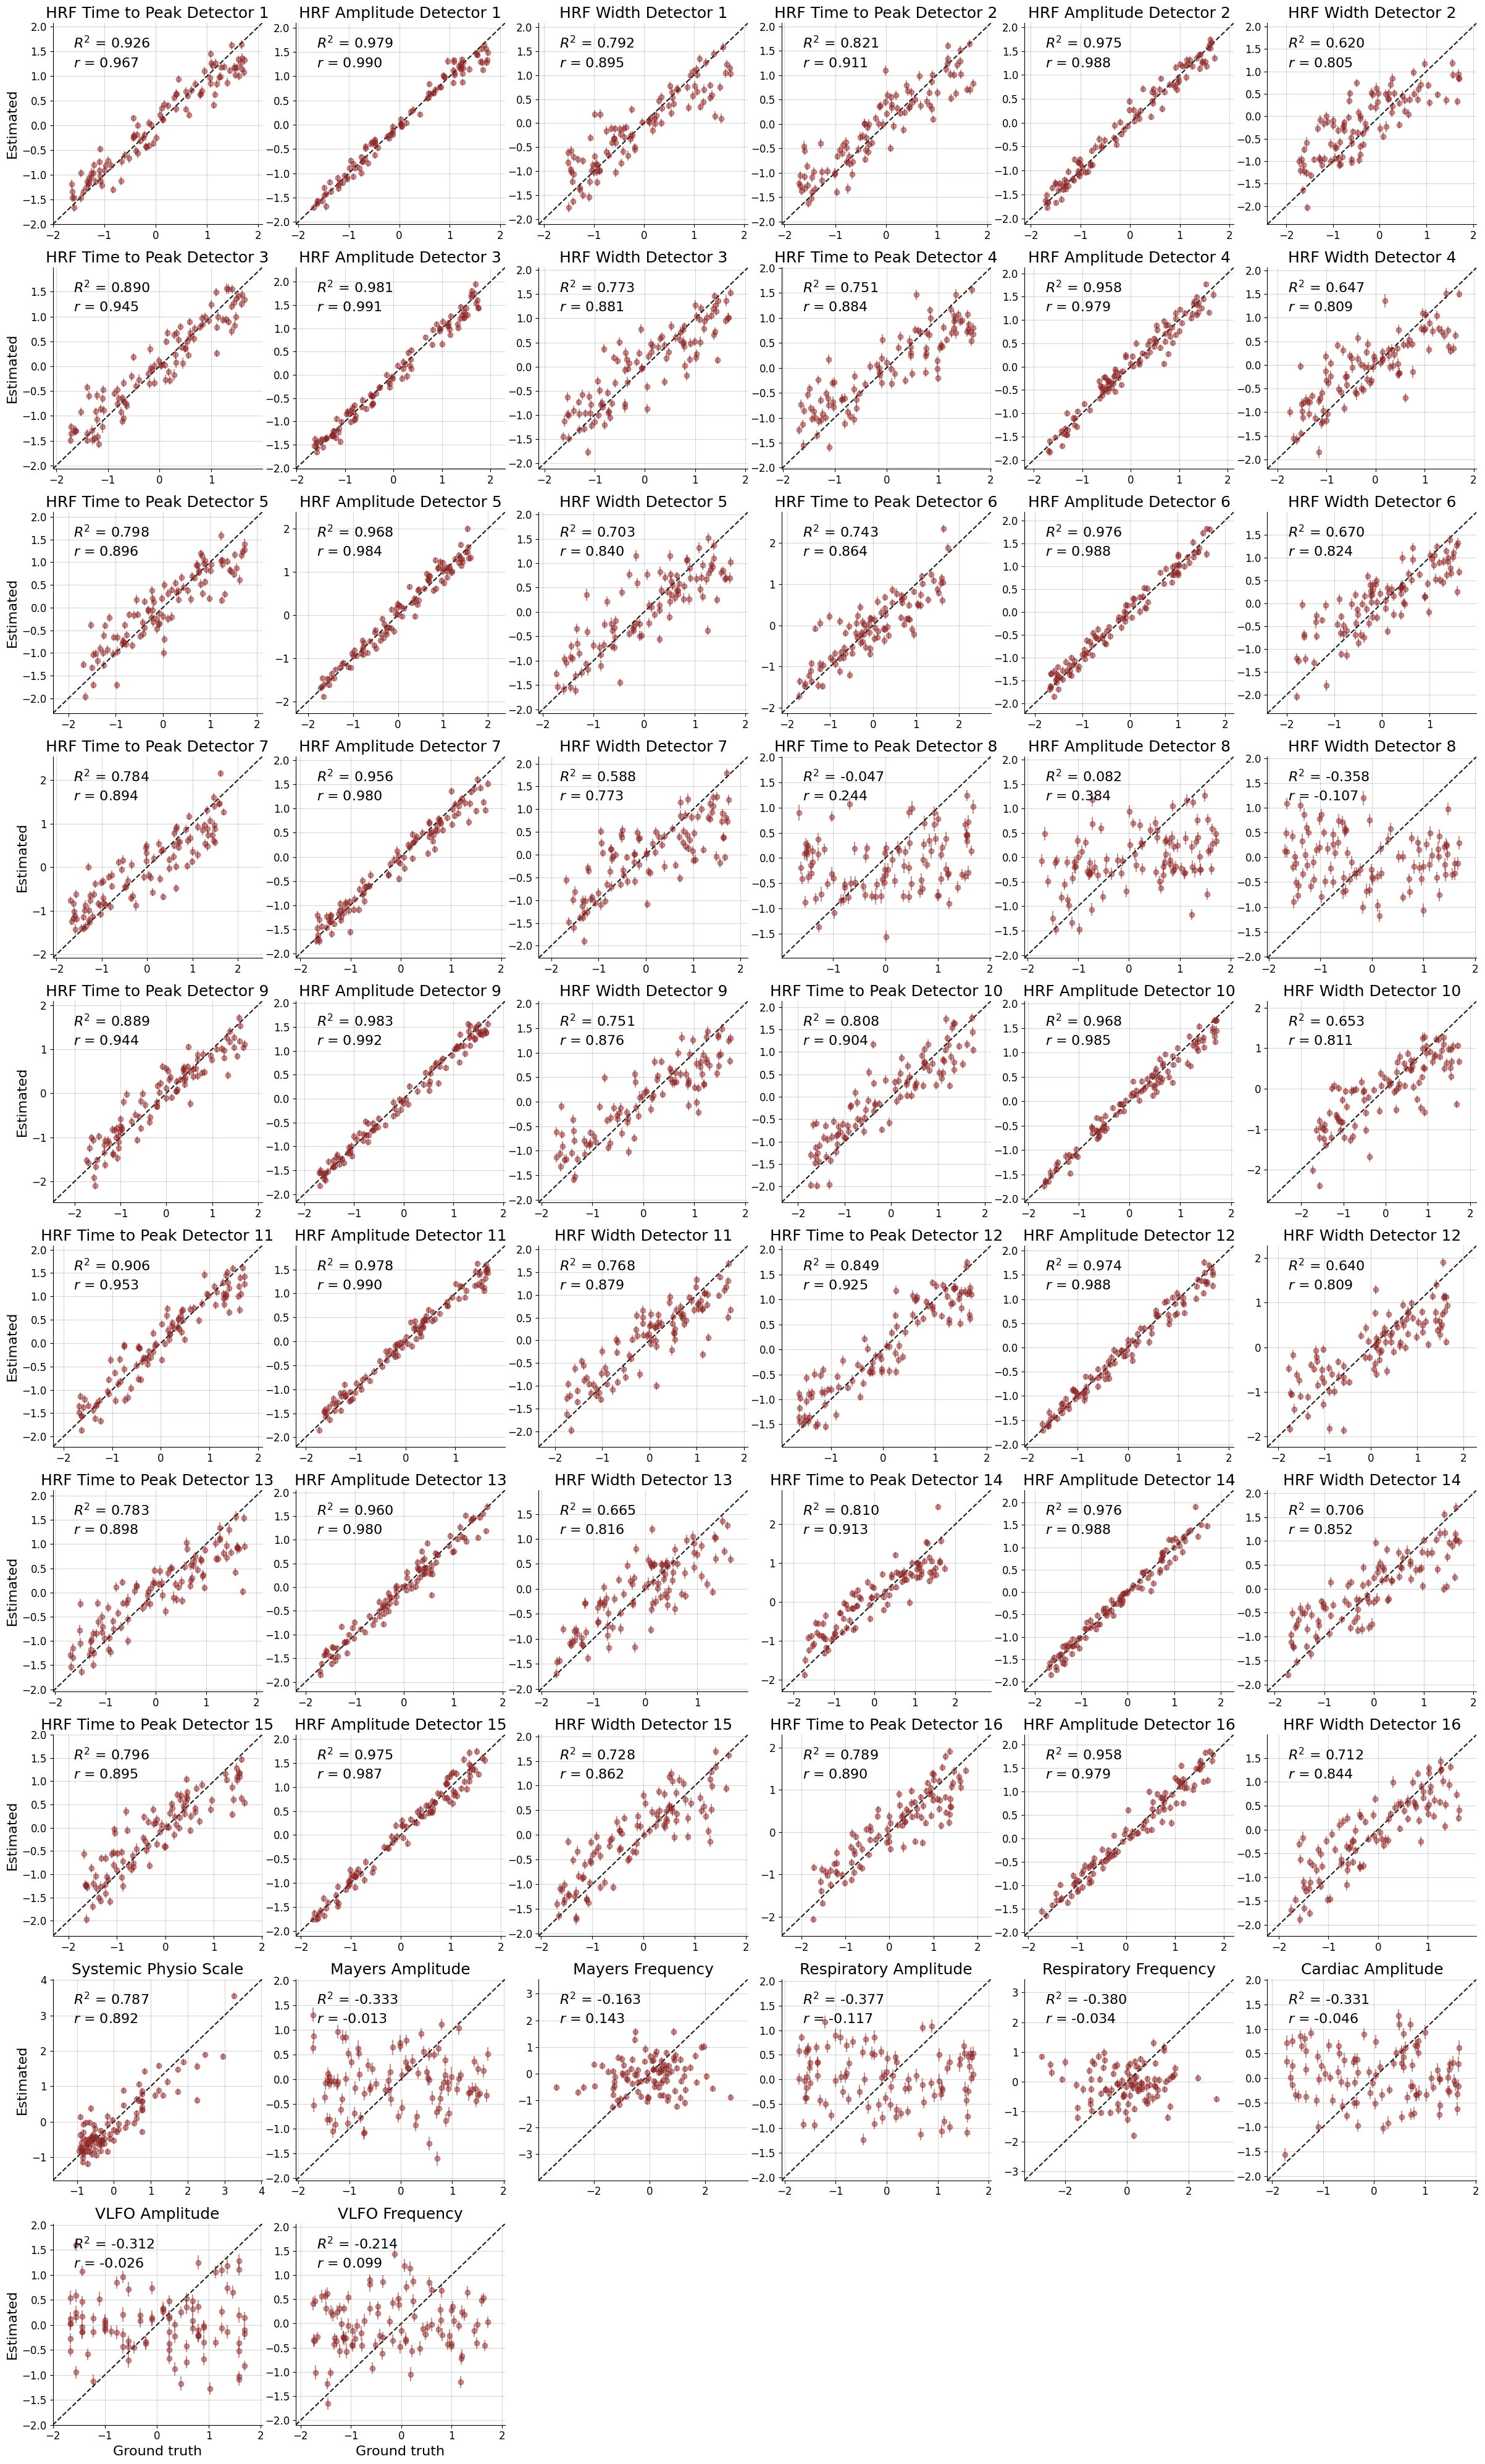

In [13]:
f = bf.diagnostics.plot_recovery(samples, test_conf['parameters'], param_names=parameter_names)

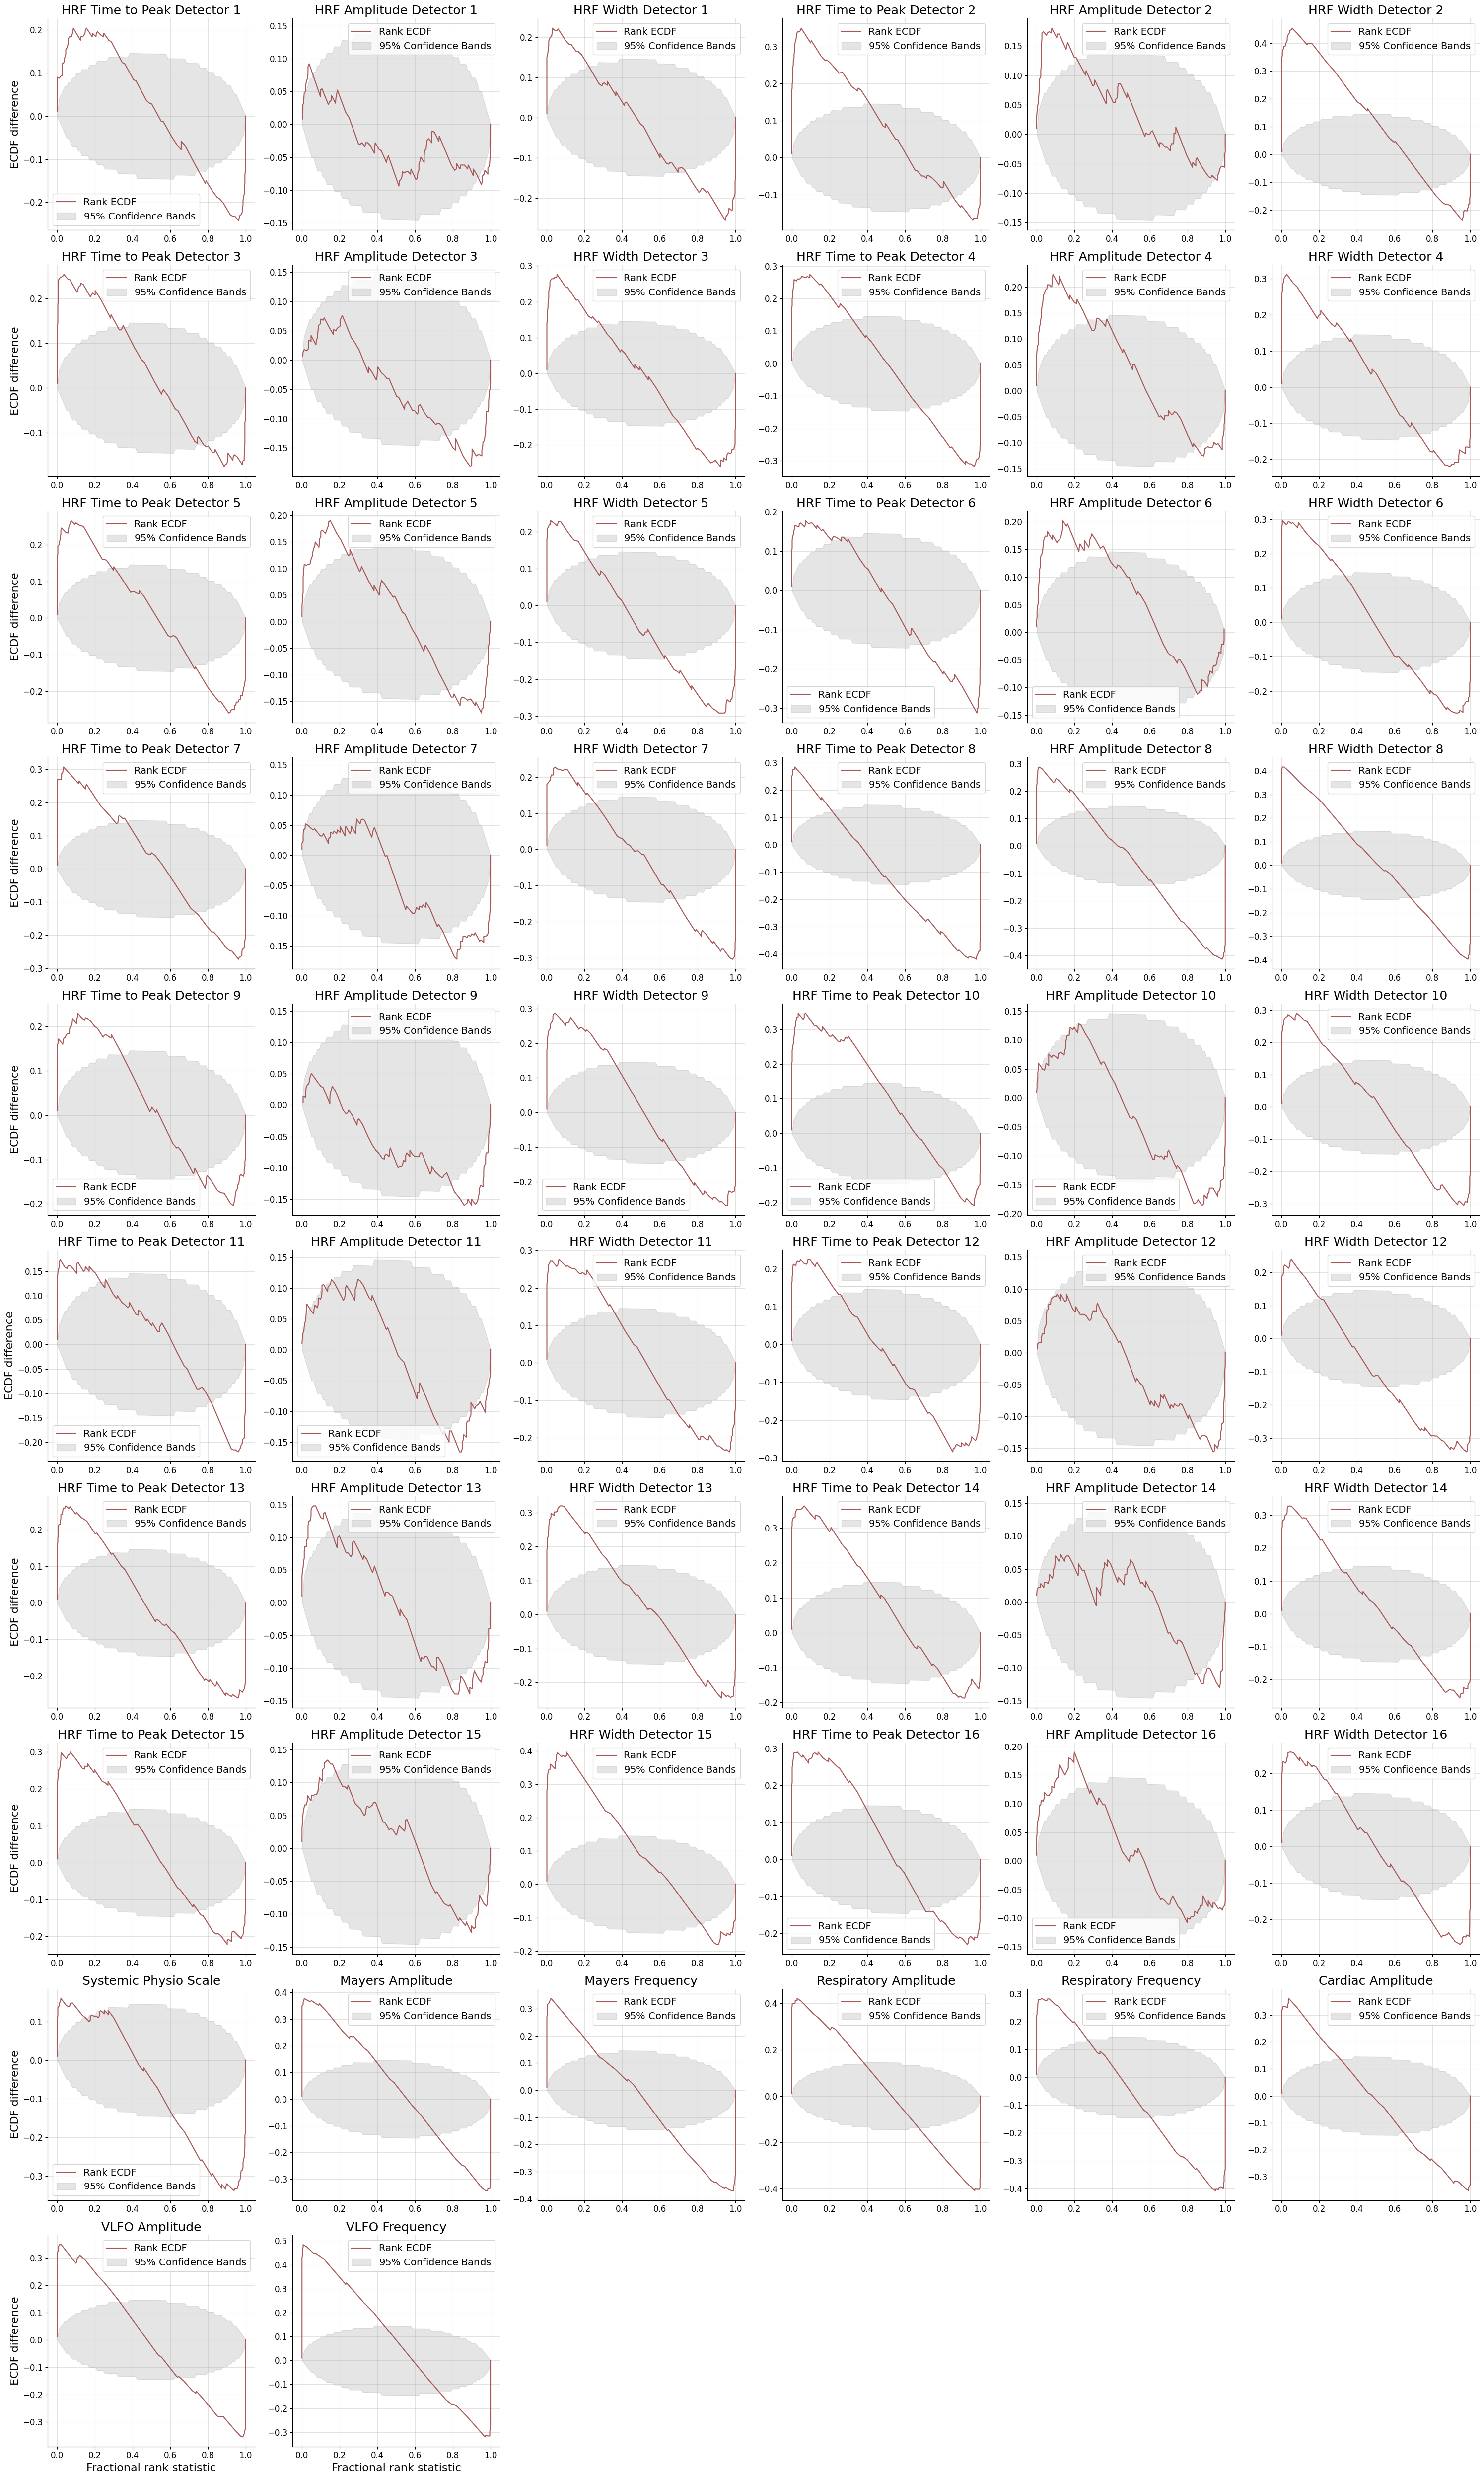

In [29]:
f = bf.diagnostics.plot_sbc_ecdf(samples, test_conf['parameters'], param_names=parameter_names, difference=True)

In [14]:
single = {k: v[0:1] for k, v in test_conf.items()}

In [16]:
samples = amortizer.sample(single, n_samples=2000, step_size=0.01)

/home/radevs/anaconda3/envs/BayesFlowDev/lib/python3.10/site-packages/seaborn/axisgrid.py:64: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout(*args, **kwargs)


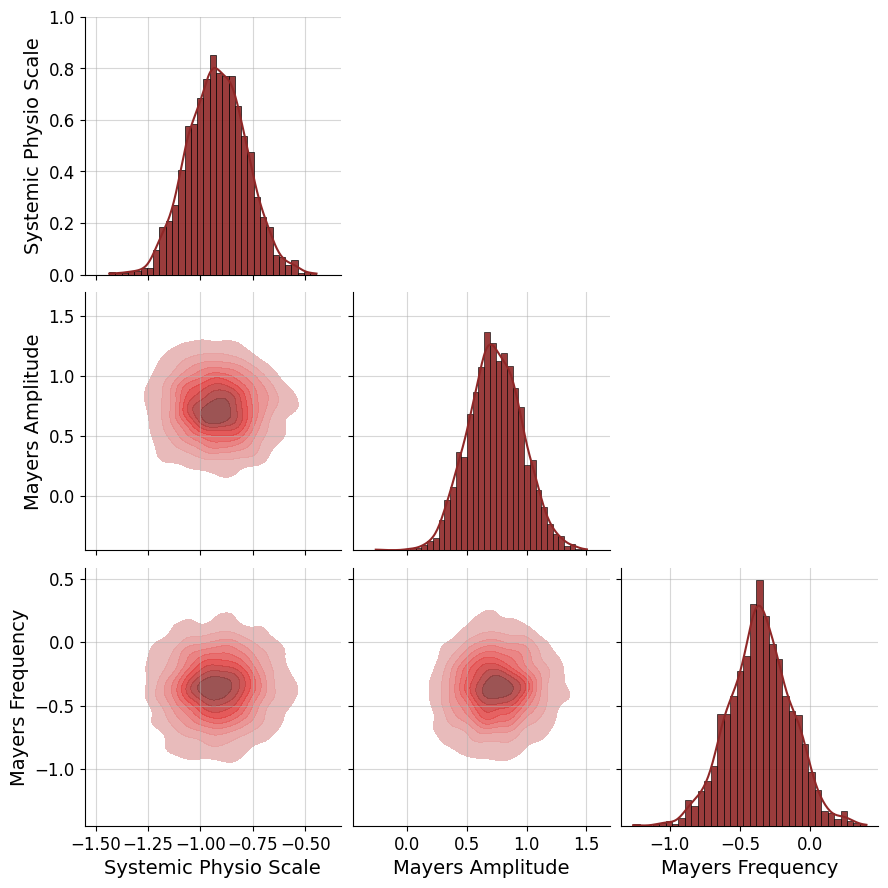

In [26]:
f = bf.diagnostics.plot_posterior_2d(samples[:, 48:51], param_names=parameter_names[48:51])